# 前提

In [1]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリをパスに追加
from deep_learning_from_scratch.common.functions import *
from deep_learning_from_scratch.common.gradient import numerical_gradient  # 勾配を計算する関数

import numpy as np
from collections import OrderedDict  # 順序付き辞書を使用, 追加した要素の順序を覚えることが可能

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx
    
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx
    
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx
    
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx
    
class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # Conv層の場合は4次元、全結合層の場合は2次元  

        # テスト時に使用する平均と分散
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward時に使用する中間データ
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx
    
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        """
        ドロップアウトの初期化
        :param dropout_ratio: ドロップアウト率（0.0〜1.0の範囲）
        """
        self.dropout_ratio = dropout_ratio  # ドロップアウト率
        self.mask = None  # ドロップアウトのマスク

    def forward(self, x, train_flg=True):
        """
        フォワードパス
        :param x: 入力データ
        :param train_flg: 学習時はTrue、推論時はFalse
        :return: ドロップアウトを適用した出力データ
        """
        if train_flg:  # 学習時のみドロップアウトを適用
            """
            削除するニューロンをFalseとして格納するマスクを生成
            np.random.rand(*x.shape)は、xと同じ形状のランダムな値を生成
            その値がドロップアウト率より大きい場合はTrue、そうでない場合はFalseとなる
            """
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio  
            return x * self.mask  # マスクを適用
        else:
            return x * (1 - self.dropout_ratio)  # 推論時はドロップアウトを適用しない

    def backward(self, dout):
        """
        バックワードパス
        :param dout: 上流からの勾配
        :return: ドロップアウトを適用した勾配
        """
        return dout * self.mask  # マスクを適用して逆伝播（ReLUと同様）

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        """
        二層のニューラルネットワークを初期化する
        input_size：入力層のサイズ
        hidden_size：隠れ層のサイズ
        output_size：出力層のサイズ
        weight_init_std：重みの初期化標準偏差（デフォルトは0.01）
        """
        # 重みとバイアスを初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # レイヤーを初期化
        self.layers = OrderedDict()  # 順序付き辞書を使用してレイヤーを保持
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])  # Affineレイヤーを追加
        self.layers['Relu1'] = Relu()  # ReLUレイヤーを追加
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])  # 2つ目のAffineレイヤーを追加
        
        # 損失関数を初期化
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        """
        入力xに対して予測を行う
        x：入力データ（NumPy配列）
        出力：予測結果（NumPy配列）
        """
        for layer in self.layers.values():
            x = layer.forward(x)

        return x
    
    def loss(self, x, t):
        """
        入力xと正解ラベルtに対して損失を計算する
        x：入力データ（NumPy配列）
        t：正解ラベル（NumPy配列）
        出力：損失値
        """
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        """
        入力xと正解ラベルtに対して精度を計算する
        x：入力データ（NumPy配列）
        t：正解ラベル（NumPy配列）
        出力：精度（0から1の範囲）
        """
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)  # tがOne-hotエンコーディングされている場合、インデックスに変換
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        """
        入力xと正解ラベルtに対して、パラメータの数値微分を計算する
        x：入力データ（NumPy配列）
        t：正解ラベル（NumPy配列）
        出力：パラメータの勾配（辞書形式）
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])  # W1の勾配を計算
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])  # b1の勾配を計算
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])  # W2の勾配を計算
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])  # b2の勾配を計算
        return grads
    
    def gradient(self, x, t):
        """
        入力xと正解ラベルtに対して、パラメータの勾配を計算する
        x：入力データ（NumPy配列）
        t：正解ラベル（NumPy配列）
        出力：パラメータの勾配（辞書形式）
        """
        # 順伝播(forward)
        self.loss(x, t)

        # 逆伝播(backward)
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        return grads
    
class MultiLayerNet:
    """全結合による多層ニューラルネットワーク

    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    weight_decay_lambda : Weight Decay（L2ノルム）の強さ
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 重みの初期化
        self.__init_weight(weight_init_std)

        # レイヤの生成
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """重みの初期値設定

        Parameters
        ----------
        weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
            'relu'または'he'を指定した場合は「Heの初期値」を設定
            'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値

            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        損失関数の値
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads
    
class MultiLayerNetExtend:
    """拡張版の全結合による多層ニューラルネットワーク
    
    Weiht Decay、Dropout、Batch Normalizationの機能を持つ

    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    weight_decay_lambda : Weight Decay（L2ノルム）の強さ
    use_dropout: Dropoutを使用するかどうか
    dropout_ration : Dropoutの割り合い
    use_batchNorm: Batch Normalizationを使用するかどうか
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0, 
                 use_dropout = False, dropout_ration = 0.5, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        # 重みの初期化
        self.__init_weight(weight_init_std)

        # レイヤの生成
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])
                
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
            
            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ration)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """重みの初期値設定

        Parameters
        ----------
        weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
            'relu'または'he'を指定した場合は「Heの初期値」を設定
            'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x

    def loss(self, x, t, train_flg=False):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x, train_flg=False)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_W = lambda W: self.loss(x, t, train_flg=True)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])
            
            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = numerical_gradient(loss_W, self.params['gamma' + str(idx)])
                grads['beta' + str(idx)] = numerical_gradient(loss_W, self.params['beta' + str(idx)])

        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads
    
class Trainer:
    """ニューラルネットの訓練を行うクラス
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimizer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprop':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))


# 学習に関するテクニック(最適化問題など)

- 最適な重みパラメータを探索する最適化手法、重みパラメータの初期値、ハイパーパラメータの設定などが重要
- 過学習の対応策
    - Weight decay
    - Dropout
    - などの正規化がある

# パラメータ更新

- 学習の目的
    - 損失関数の値をできるだけ小さくするパラメータの探査
    - 最適なパラメータを見つける問題を**最適化**という
        - パラメータは複雑でムズイ
- 今までは、パラメータの勾配を使って最適化していた
    - **確率的勾配降下法（SGD）** という


## 冒険家の話
- 例の話
## SGD(確率的勾配降下法)
- SGDの式
    $$W ← W - ŋ\frac{∂L}{∂W}$$
    - W：更新する重みパラメータ
    - ∂L/∂W：Wに関する損失関数の勾配
    - ŋ：学習係数（0.01や0.001などの値で初期化）
    

In [2]:
class SGD:
    def __init__(self, lr=0.01):
        """
        初期化
        lr: 学習率(Learning Rate)
        """
        self.lr = lr

    def update(self, params, grads):
        """
        パラメータの更新
        :param params: パラメータの辞書
        :param grads: 勾配の辞書
        """
        for key in params.keys():
            params[key] -= self.lr * grads[key]

```py
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリをパスに追加

network = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
optimizer = SGD()

for i in range(10000):
    x_batch, t_batch = get_mini_batch()  # ミニバッチを取得する関数（実装は省略）
    grads = network.gradient(x_batch, np.random.rand(100, 10))  # 勾配を計算
    params = network.params
    optimizer.update(params, grads)
```
- optimizer：「最適化を行う者」という意味の単語
    - パラメータの更新を責任持って遂行するもの
- 最適化を行うクラスを分離して実装することで、機能のモジュール化が容易になる

## SGDの欠点
- SGDは単純で実装も簡単
- 問題によって非効率
- Ex)関数の最小値を求める問題
$$f(x, y) = \frac{1}{20}x^2 + y^2$$

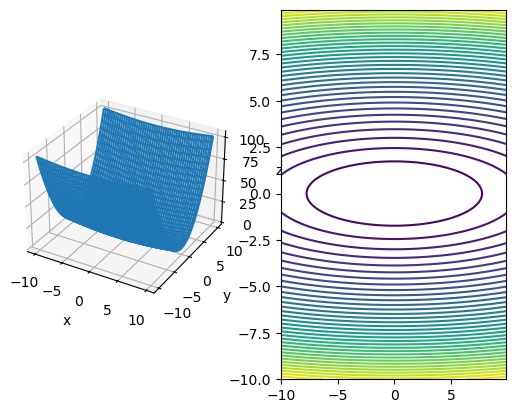

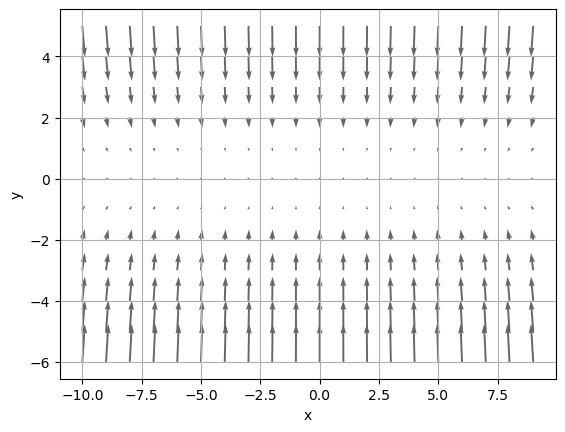

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def _numerical_gradient_no_batch(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val  # 値を元に戻す
    return grad

def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad

def f(x):
    return (1 / 20) * np.power(x[0], 2) + np.power(x[1], 2)

x = np.arange(-10, 10, 0.1)
y = np.arange(-10, 10, 0.1)

fig = plt.figure()  # 図を作成
ax_3d = fig.add_subplot(1, 2, 1, projection='3d')  # 3Dプロットを作成
ax_toukou = fig.add_subplot(1, 2, 2)  # 等高線プロットを作成

# 3dグラフの描画
X1, X2 = np.meshgrid(x, y)  # x1とx2のメッシュグリッドを作成
z = ((1 / 20) * np.power(X1, 2)) + np.power(X2, 2)  # zの値を計算
ax_3d.plot_wireframe(X1, X2, z)  # サーフェスプロットを描画
ax_3d.set_xlabel('x')  # x軸のラベルを設定
ax_3d.set_ylabel('y')  # y軸のラベルを設定
ax_3d.set_zlabel('z')  # z軸のラベルを設定

# 等高線の表示
cont = ax_toukou.contour(X1, X2, z, levels=40)  # 等高線を描画
plt.show()

x = np.arange(-10, 10, 1)
y = np.arange(-6, 6, 1)
X, Y = np.meshgrid(x, y)  # xとyのメッシュグリッドを作成

X = X.flatten()  # Xを1次元配列に変換
Y = Y.flatten()  # Yを1次元配列に変換

grad = numerical_gradient(f, np.array([X, Y]).T).T  # 勾配を計算

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.draw()
plt.show()

- お椀をx軸に伸ばしたような形状
- 勾配に関しては...
    - y軸方向：急な傾斜
    - x軸方向：緩やかな傾斜

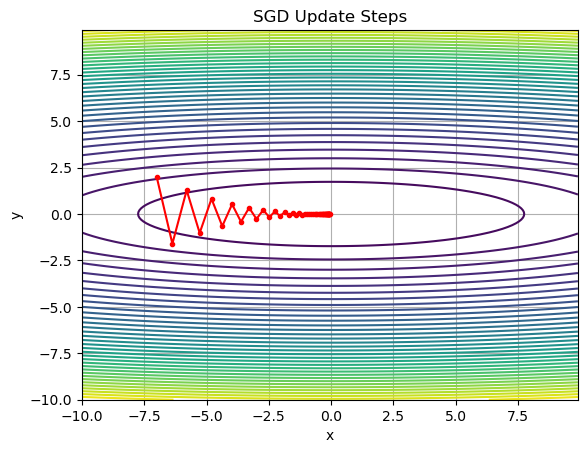

In [4]:
# 等高線の表示
plt.figure()
cont = plt.contour(X1, X2, z, levels=40)  # 等高線を描画

# ((1 / 20) * np.power(X1, 2)) + np.power(X2, 2)における初期値(-7.0, 2.0)のSGDの更新を確認
x = np.array([-7.0, 2.0])  # 初期値
f = lambda x: (1 / 20) * np.power(x[0], 2) + np.power(x[1], 2)  # 関数fを定義
sgd = SGD(lr=0.9)  # SGDのインスタンスを作成, lrは高く設定

x_history = [x.copy()]

for i in range(50):
    grad = numerical_gradient(f, x)  # 勾配を計算
    sgd.update({'x': x}, {'x': grad})  # パラメータを更新
    x_history.append(x.copy())  # 更新後のxを履歴に追加

# 更新履歴をプロット
x_history = np.array(x_history)  # 履歴をNumPy配列に変換
plt.plot(x_history[:, 0], x_history[:, 1], marker='o', color='red', markersize=3, label='SGD Steps')  # 更新ステップをプロット
    
plt.xlabel('x')
plt.ylabel('y')
plt.title('SGD Update Steps')
plt.grid()
plt.show()  # プロットを表示

- じゃあ、確率的勾配降下法を使って更新経路を見ると?
    - lr(学習率)を大きくしすぎる(0.9)と上記のようになる(最小値(0,0)へジグザグに動く)
        - 学習率が大きくなると、**パラメータの更新量が増加**
        - lrが0.1ならそこまで影響はない
            - 学習率が小さい＝更新量が少ない＝学習が進みにくいという問題も...!
    - つまり、SGDの欠点は関数の形状が等方的でないと（伸びた形状の関数でないと）非効率な経路で探索することになる
    - 詳しくは、[こちら](https://dx-consultant-fast-evolving.com/gradient-descent/)のサイトがわかりやすそう
- 原因は？
    - 勾配の方向が**本来の最小値ではない方向をさしている**
- 他の方法が考えられる！！
    - **Momentum**
    - **AdaGrad**
    - **Adam**

## Momentum
- モーメンタム：
    - 運動量という意味
- 数式
    $$v ← αv - ŋ\frac{∂L}{∂W}$$
    $$W ← W + v$$
    - W：更新する重みパラメータ
    - ∂L/∂W：Wに関する損失関数の勾配
    - ŋ：学習係数
    - v
        - 物理でいうところの「速度」
        - 上の式は物体が勾配方向に力を受け、その力によって物体の速度が加算される物理法則を表現
        - αvは、物体が何も力を受けないときに徐々に減速するための役割（摩擦や空気抵抗に匹敵）
            - α：0.9などの値を設定 
- イメージ
    - ボールが地面を転がるような動き

In [5]:
import numpy as np

class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        """
        初期化
        lr: 学習率(Learning Rate)
        momentum: モーメンタム係数
        """
        self.lr = lr
        self.momentum = momentum
        self.v = None  # 速度、勾配の更新を保持する変数

    def update(self, params, grads):
        """
        パラメータの更新
        :param params: パラメータの辞書
        :param grads: 勾配の辞書
        """
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]  # モーメンタム更新
            params[key] += self.v[key]  # パラメータ更新

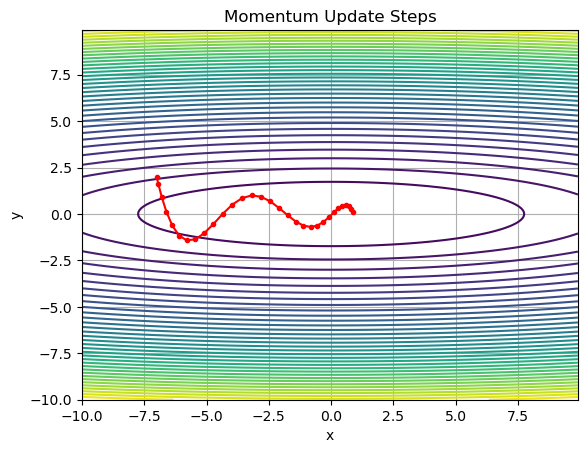

In [6]:
# 等高線の表示
plt.figure()
cont = plt.contour(X1, X2, z, levels=40)  # 等高線を描画

# ((1 / 20) * np.power(X1, 2)) + np.power(X2, 2)における初期値(-7.0, 2.0)のMomentumの更新を確認
x = np.array([-7.0, 2.0])  # 初期値
f = lambda x: (1 / 20) * np.power(x[0], 2) + np.power(x[1], 2)  # 関数fを定義
sgd = Momentum(lr=0.1)  # SGDのインスタンスを作成

x_history = [x.copy()]

for i in range(30):
    grad = numerical_gradient(f, x)  # 勾配を計算
    sgd.update({'x': x}, {'x': grad})  # パラメータを更新
    x_history.append(x.copy())  # 更新後のxを履歴に追加

# 更新履歴をプロット
x_history = np.array(x_history)  # 履歴をNumPy配列に変換
plt.plot(x_history[:, 0], x_history[:, 1], marker='o', color='red', markersize=3, label='SGD Steps')  # 更新ステップをプロット
    
plt.xlabel('x')
plt.ylabel('y')
plt.title('Momentum Update Steps')
plt.grid()
plt.show()  # プロットを表示

- Momentumを使用した更新経路は？
    - ボールがお椀を転がるような動きをする
    - SGDと比べて**ジグザグ度合が軽減！**
        - x軸方向に受ける力は微小ながら、常に加速
        - y軸方向にかかる力は大きいが、正と負の方向の力を交互に受けて打ち消しあい、y軸方向の速度が安定しない
> Momentumのメリット
>- ジグザクの動きを軽減
>- x軸方向に早く近づくことが可能

## AdaGrad
- ニューラルネットワークの学習では **「学習率(lr)」の値**が重要
    - lrが小さい：学習に時間がかかる
    - lrが大きい：発散して正しく学習できない
- lrに関する有効テクニック：**学習係数の減衰(LR decay)**
    - 学習が進むにつれてlrを小さくする
- 学習率を徐々に下げる＝パラメータ「全体」の学習係数の値を一括して下げる
    - 発展させたのが**AdaGrad**
> **AdaGrad**  
> パラメータの**要素ごとに適応的に学習係数を調整しながら学習を行う**手法  
> イメージ：「1つひとつ」のパラメータに対して"オーダーメイド"の値を拵える
- 更新式
    $$h ← h + \frac{∂L}{∂W}⊙\frac{∂L}{∂W}$$
    $$W ← W - ŋ\frac{1}{√h}\frac{∂L}{∂W}$$
    - （⊙：行列の要素ごとの掛け算をあらわす）
    - W：更新する重みパラメータ
    - ∂L/∂W：Wに関する損失関数の勾配
    - ŋ：学習係数(lr)
    - h：これまで経験した勾配の2乗和
        - パラメータ更新時に1/√hを乗算することで、学習のスケールを調整
        - パラメータが大きく更新された（勾配が大きかった）要素は、学習係数が小さくなることを示す  
- 余談：AdaGrad２乗和はすべて記録する
    - 学習が進めば進むほど、更新度合は小さくなる（無限に進めばいつかは0）
    - この問題を解決したのが**RMSProp**
        - 過去の勾配を徐々に忘れて、新しい勾配の情報が大きく反映されるように加算


In [7]:
class AdaGrad:
    def __init__(self, lr=0.01):
        """
        初期化
        lr: 学習率(Learning Rate)
        """
        self.lr = lr
        self.h = None  # 勾配の二乗和を保持する変数

    def update(self, params, grads):
        """
        パラメータの更新
        :param params: パラメータの辞書
        :param grads: 勾配の辞書
        """
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] ** 2  # 勾配の二乗和を更新
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)    # パラメータ更新, 1e-7はゼロ除算を防ぐための小さな値

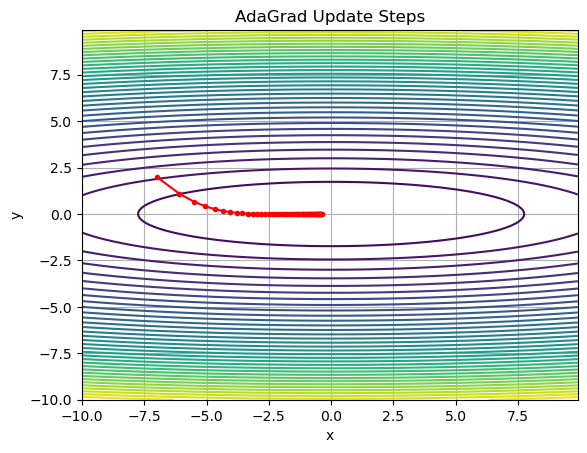

In [8]:
# 等高線の表示
plt.figure()
cont = plt.contour(X1, X2, z, levels=40)  # 等高線を描画

# ((1 / 20) * np.power(X1, 2)) + np.power(X2, 2)における初期値(-7.0, 2.0)のMomentumの更新を確認
x = np.array([-7.0, 2.0])  # 初期値
f = lambda x: (1 / 20) * np.power(x[0], 2) + np.power(x[1], 2)  # 関数fを定義
sgd = AdaGrad(lr=0.9)  # SGDのインスタンスを作成

x_history = [x.copy()]

for i in range(50):
    grad = numerical_gradient(f, x)  # 勾配を計算
    sgd.update({'x': x}, {'x': grad})  # パラメータを更新
    x_history.append(x.copy())  # 更新後のxを履歴に追加

# 更新履歴をプロット
x_history = np.array(x_history)  # 履歴をNumPy配列に変換
plt.plot(x_history[:, 0], x_history[:, 1], marker='o', color='red', markersize=3, label='SGD Steps')  # 更新ステップをプロット
    
plt.xlabel('x')
plt.ylabel('y')
plt.title('AdaGrad Update Steps')
plt.grid()
plt.show()  # プロットを表示

- AdaGradを使用した更新経路は？
    - 最小値に向かって効率的に動いている
    - y軸方向への更新度合が徐々に弱められていき、ジグザグの動きが軽減される

## Adam
- MometumとAdaGradの利点を融合させたもの
    - Momentum：ボールがお椀を転がるように物理法則に準じる動き
    - AdaGrad：パラメータ要素ごとに、適応化に更新ステップを調整
    - この２つを組み合わせることで、効率的にパラメータ空間を探索することが可能
    - ハイパーパラメータに「**バイアス補正（偏りの修正）**」が行われている
- 具体的には?
    1. 過去の勾配の平均を計算（1次モーメント） → 「どの方向に動くべきか」
    2. 過去の勾配の大きさの平均を計算（2次モーメント） → 「どれくらいの大きさで動くべきか」
    3. これらを使って、学習率を調整しながらパラメータを更新

In [9]:
class Adam:
    """Adam (http://arxiv.org/abs/1412.6980v8)"""
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        """
        初期化
        lr: 学習率(Learning Rate)
        beta1: 一次モーメントの指数移動平均の係数（標準設定値：0.9）
        beta2: 二次モーメントの指数移動平均の係数（標準設定値：0.999）
        betaはバイアス補正のための係数
        """
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

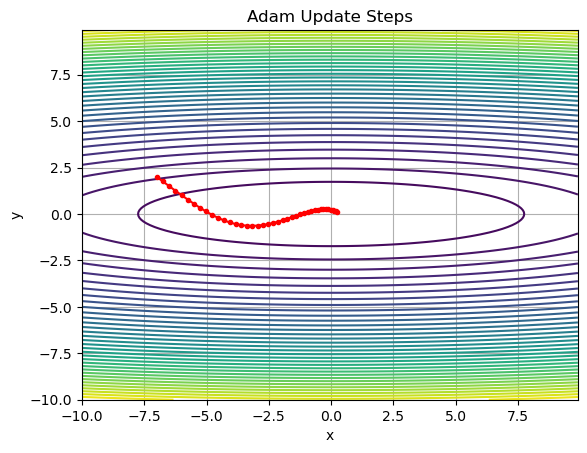

In [10]:
# 等高線の表示
plt.figure()
cont = plt.contour(X1, X2, z, levels=40)  # 等高線を描画

# ((1 / 20) * np.power(X1, 2)) + np.power(X2, 2)における初期値(-7.0, 2.0)のMomentumの更新を確認
x = np.array([-7.0, 2.0])  # 初期値
f = lambda x: (1 / 20) * np.power(x[0], 2) + np.power(x[1], 2)  # 関数fを定義
sgd = Adam(lr=0.25)  # SGDのインスタンスを作成

x_history = [x.copy()]

for i in range(40):
    grad = numerical_gradient(f, x)  # 勾配を計算
    sgd.update({'x': x}, {'x': grad})  # パラメータを更新
    x_history.append(x.copy())  # 更新後のxを履歴に追加

# 更新履歴をプロット
x_history = np.array(x_history)  # 履歴をNumPy配列に変換
plt.plot(x_history[:, 0], x_history[:, 1], marker='o', color='red', markersize=3, label='SGD Steps')  # 更新ステップをプロット
    
plt.xlabel('x')
plt.ylabel('y')
plt.title('Adam Update Steps')
plt.grid()
plt.show()  # プロットを表示

- Adamを使用した更新経路は？
    - Momentomと同様に、お椀の上をボールが転がるような動き
    - ボールの左右への揺れが軽減

## どの更新手法を用いるか
- 4つの手法の結果を比較する

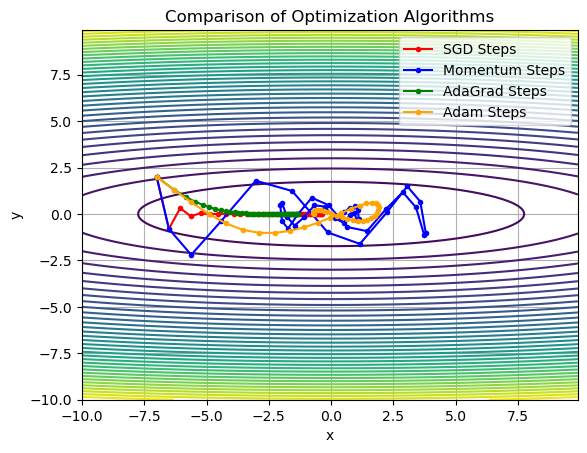

In [11]:
# 等高線の表示
plt.figure()
cont = plt.contour(X1, X2, z, levels=40)  # 等高線を描画

sgd_x = np.array([-7.0, 2.0])  # 初期値
momentum_x = np.array([-7.0, 2.0])  # 初期値
adagrad_x = np.array([-7.0, 2.0])  # 初期値
adam_x = np.array([-7.0, 2.0])  # 初期値
f = lambda x: (1 / 20) * np.power(x[0], 2) + np.power(x[1], 2)  # 関数fを定義

# sgd = SGD(lr=0.9)  
# momentum = Momentum(lr=0.1)
# adagrad = AdaGrad(lr=0.9)
# adam = Adam(lr=0.25)  

lr = 0.7
sgd = SGD(lr=lr)  
momentum = Momentum(lr=lr)
adagrad = AdaGrad(lr=lr)
adam = Adam(lr=lr)  

sgd_x_history = [sgd_x.copy()]
momentum_x_history = [momentum_x.copy()]
adagrad_x_history = [adagrad_x.copy()]
adam_x_history = [adam_x.copy()]

for i in range(40):
    sgd_grad = numerical_gradient(f, sgd_x)  # 勾配を計算
    sgd.update({'x': sgd_x}, {'x': sgd_grad})  # SGDのパラメータを更新
    sgd_x_history.append(sgd_x.copy())  # 更新後のxを履歴に追加

    momentum_grad = numerical_gradient(f, momentum_x)  # 勾配を計算
    momentum.update({'x': momentum_x}, {'x': momentum_grad})  # Momentumのパラメータを更新
    momentum_x_history.append(momentum_x.copy())  # 更新後のxを履歴に追加

    adagrad_grad = numerical_gradient(f, adagrad_x)  # 勾配を計算
    adagrad.update({'x': adagrad_x}, {'x': adagrad_grad})  # AdaGradのパラメータを更新
    adagrad_x_history.append(adagrad_x.copy())  # 更新後のxを履歴に追加

    adam_grad = numerical_gradient(f, adam_x)  # 勾配を計算
    adam.update({'x': adam_x}, {'x': adam_grad})  # Adamのパラメータを更新
    adam_x_history.append(adam_x.copy())  # 更新後のxを履歴に追加


# 更新履歴をプロット
sgd_x_history = np.array(sgd_x_history)  # 履歴をNumPy配列に変換
momentum_x_history = np.array(momentum_x_history)  # 履歴をNumPy配列に変換
adagrad_x_history = np.array(adagrad_x_history)  # 履歴をNumPy配列に変換
adam_x_history = np.array(adam_x_history)  # 履歴をNumPy配列に変換

plt.plot(sgd_x_history[:, 0], sgd_x_history[:, 1], marker='o', color='red', markersize=3, label='SGD Steps')  # SGDの更新ステップをプロット
plt.plot(momentum_x_history[:, 0], momentum_x_history[:, 1], marker='o', color='blue', markersize=3, label='Momentum Steps')  # Momentumの更新ステップをプロット
plt.plot(adagrad_x_history[:, 0], adagrad_x_history[:, 1], marker='o', color='green', markersize=3, label='AdaGrad Steps')  # AdaGradの更新ステップをプロット
plt.plot(adam_x_history[:, 0], adam_x_history[:, 1], marker='o', color='orange', markersize=3, label='Adam Steps')  # Adamの更新ステップをプロット

plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparison of Optimization Algorithms')
plt.grid()
plt.legend()  # 凡例を表示
plt.show()  # プロットを表示

- 上の図を見ると、AdaGradが最もよさそうに見える（lr=0.7の時）
- BUT...
    - 解くべき問題によって結果が変わるので注意が必要
    - ハイパラ（学習率lr）などの設定値によっても変わる
- すべての問題に対して優れた手法はない！！
    - それぞれに特徴があり、得意な問題、不得意な問題がある

## MINISTデータセットによる更新手法の比較
- SGD, Momentum, AdaGrad, Adamの速度を比較
- 手書き数字認識を対象(MNIST)

===========iteration:0===========
SGD:2.3024797946758624
Momentum:2.302107015817731
AdaGrad:2.2327340464557466
Adam:2.2960257300688864
===========iteration:4000===========
SGD:0.34799686774579475
Momentum:0.15466316444656694
AdaGrad:0.23898854876569803
Adam:0.092063698613326
===========iteration:8000===========
SGD:0.14804962340679315
Momentum:0.03613674864050952
AdaGrad:0.07962010810637662
Adam:0.010282023073662525


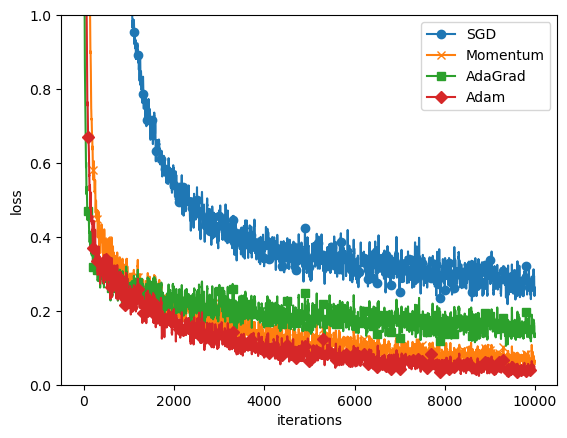

In [12]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリをパスに追加
import numpy as np
from deep_learning_from_scratch.common.functions import *
from deep_learning_from_scratch.common.util import smooth_curve
from deep_learning_from_scratch.dataset.mnist import load_mnist
import matplotlib.pyplot as plt

# MNISTデータセットの読み込み
(img_train, label_train), (img_test, label_test) = load_mnist(normalize=True, one_hot_label=True)  # 正規化とone-hot表現を適用

# ハイパーパラメータの設定
iters_num = 10000  # 学習の繰り返し回数
train_size = img_train.shape[0]  # 学習データのサイズ(60000)
batch_size = 100  # バッチサイズ
learning_rate = 0.1  # 学習率

train_loss_list = []  # 学習時の損失を格納するリスト
train_acc_list = []  # 学習時の精度を格納するリスト
test_acc_list = []  # テスト時の精度を格納するリスト
iter_per_epoch = max(train_size // batch_size, 1)  # 1エポックあたりの繰り返し数

optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = TwoLayerNet(
        input_size=784,
        hidden_size=50,
        output_size=10
        )
    train_loss[key] = []    
# network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)  # ネットワークのインスタンスを作成

for i in range(iters_num):
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size)  # ランダムにバッチサイズ分のインデックスを取得(60000の中から100個のインデックスをランダムに選ぶ)
    x_batch = img_train[batch_mask]  # ミニバッチの画像データ
    t_batch = label_train[batch_mask]  # ミニバッチの正解データ

    # 勾配の計算
    # grad = network.numerical_gradient(x_batch, t_batch)  # 勾配を計算（遅い版）
    # grad = network.gradient(x_batch, t_batch)  # 勾配を計算（高速版）

    # パラメータの更新
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    # 学習経過を記録
    if i % 4000 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

# 学習結果のプロット
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(iters_num)  # x軸の値（イテレーション数）
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

- 教科書では、MultiLayerNetworkを使用していましたが、とりあえず今まで通りのTwoLayerNetworkでまわしてみた結果が上図
    - MultiLayerならiterationが少なくて済む
- 結果：
    - SGDよりも他の３種類の最適化手法の方が早く学習できている
    - 若干ではあるがAdaGradの学習は速い
- **一般的にはSGDよりも他の３つの手法のほうが速く学習でき**て、時には最終的な認知性能も高くなる

# 重みの初期値

## 重みの初期値を0にする？
- **Weight decay(荷重減衰)**
    - 過学習を抑え、汎用化性能を高めるテクニック
    - 重みパラメータの値が小さくなるように学習を行うことを目的とする
    - 重みが小さくなる＝過学習しにくい
- 重みを小さくするには？
    - 初期値もできるだけ小さくする
    - 現状は以下のように、ガウス分布から生成した値を0.01倍したい小さな値を用いた（標準偏差が0.01のガウス分布）
        ```py
        0.01 * np.random.randn(10, 100)
        ```
- 小さくする＝０にすれば？
    - **Bad Idea**
    - 正しい学習が行えない
    - 重みを均一な値に設定してはいけない！！
    - なぜ？
        - 誤差逆伝播法において、すべての重みの値が均一に更新されてしまい、たくさんの重みを持つ意味がなくなってしまう！

## 隠れ層のアクティベーション分布
- **アクティベーション**：活性化関数のあとの出力データ
- 重みの初期値によってアクティベーションがどのように変化するかを調べる
    - ５層のニューラルネットワーク（活性化関数：シグモイド関数）
    - ランダムに作成した入力データを流し、各層のアクティベーションデータの分布をヒストグラムで描画する

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def five_layer_network(standard_deviation=1):
    """ 5層のニューラルネットワークを構築し、各層のアクティベーションを計算する """
    x = np.random.randn(1000, 100)  # 1000行100列のランダムなデータを生成
    node_num = 100  # 各隠れ層のノード（ニューロン数）
    hidden_layer_size = 5  # 隠れ層の数
    activations = {}  # ここにアクティベーションの値を格納

    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i - 1]  # 前の層の出力を次の層の入力に設定

        W = np.random.randn(node_num, node_num) * standard_deviation  # 基準値：標準偏差1の正規分布から重みを初期化

        z = np.dot(x, W)  # 行列の積を計算
        a = sigmoid(z)  # シグモイド関数を適用
        activations[i] = a  # アクティベーションの値を保存
    return activations

- 5つの層があり、それぞれの層で100個のニューロン数を保有
    - 入力データ：1000個のガウス分布でランダム生成
    - 活性化関数：sigmoid関数
    - アクティベーション結果をactivationsに格納
- [注意]重みのスケール
    - 今回は**標準偏差が1**のガウス分布
    - この標準偏差をかえることで、アクティベーションの分布がどのように変化していくかを観察できる

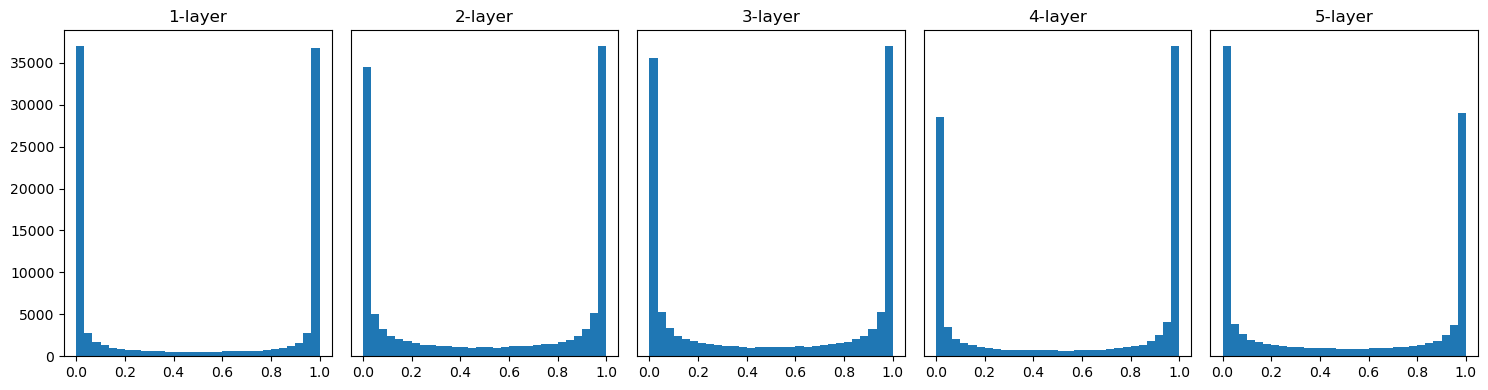

In [14]:
# ヒストグラムの表示
activations = five_layer_network(standard_deviation=1)  # 5層のニューラルネットワークを構築
plt.figure(figsize=(15, 4)) 
for i , a in activations.items():
    plt.subplot(1, len(activations), i + 1)  # 1行hidden_layer_size列のサブプロットを作成
    plt.title(str(i + 1) + "-layer")  # タイトルを設定
    plt.hist(a.flatten(), bins=30, range=(0, 1))  # ヒストグラムを表示
    if i != 0:
        plt.yticks([])
        

plt.tight_layout()  # レイアウトを調整
plt.show()  # プロットを表示

- 重みの標準偏差1の時の結果
    - 各層のアクティベーションは、**0と1に偏った分布**になっている
- シグモイド関数  
    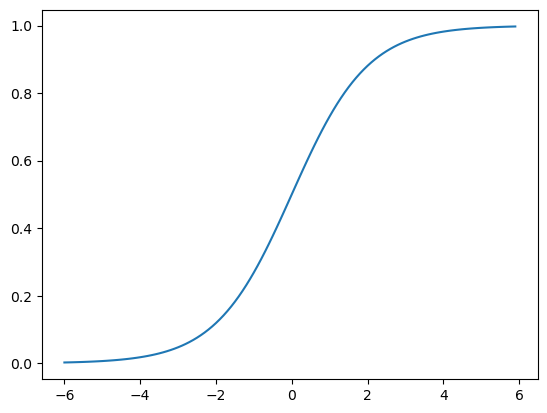
    - 上図のようにS字に湾曲
    - 出直が0または1に近づくにつれて、微分の値は0に近づく
        - これにより、逆伝播での勾配の値がどんどん小さくなって消えてしまう
        - これを**勾配消失**という

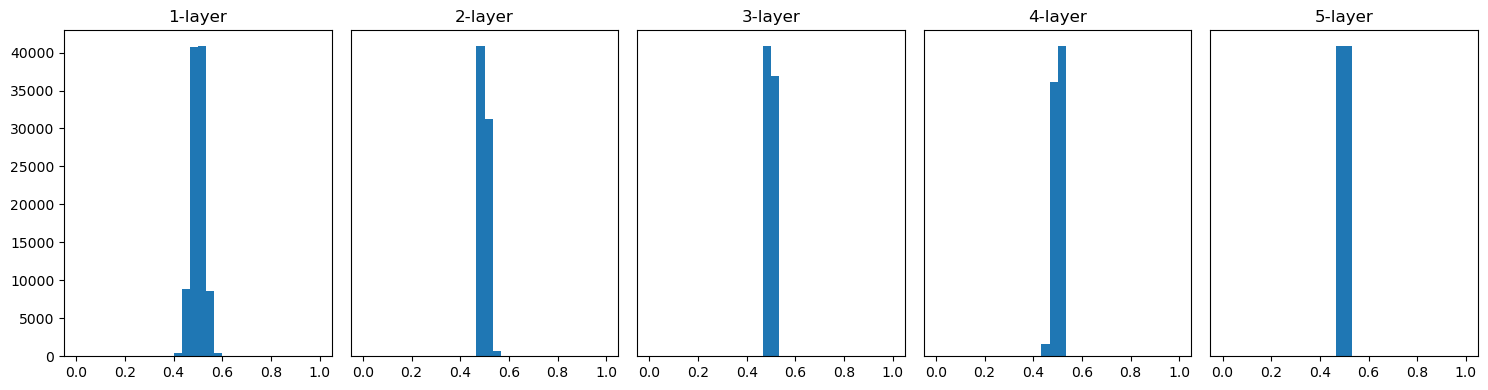

In [15]:
activations = five_layer_network(standard_deviation=0.01)  # 5層のニューラルネットワークを構築
plt.figure(figsize=(15, 4)) 
for i , a in activations.items():
    plt.subplot(1, len(activations), i + 1)  # 1行hidden_layer_size列のサブプロットを作成
    plt.title(str(i + 1) + "-layer")  # タイトルを設定
    plt.hist(a.flatten(), bins=30, range=(0, 1))  # ヒストグラムを表示
    if i != 0:
        plt.yticks([])
        

plt.tight_layout()  # レイアウトを調整
plt.show()  # プロットを表示

- 重みの標準偏差0.01の時の結果
    - 0.5付近に集中する分布
    - アクティベーションに偏りがある
- この結果からわかること
    - 勾配消失の問題は起きない
    - **表現力の点で大きな問題**がある
        - 複数のニューロンがほとんど同じ値を値を出力する＝複数のニューロンが存在する意味がない
        - 各層のアクティベーション分布は、適度な広がりを持つことが求められる

- 推奨される重みの初期値
    - **Xavierの初期値**：
        - ノードの個数をnとした場合
        $$\frac{1}{√n}$$
        の標準偏差を持つ分布を使うと良い！！


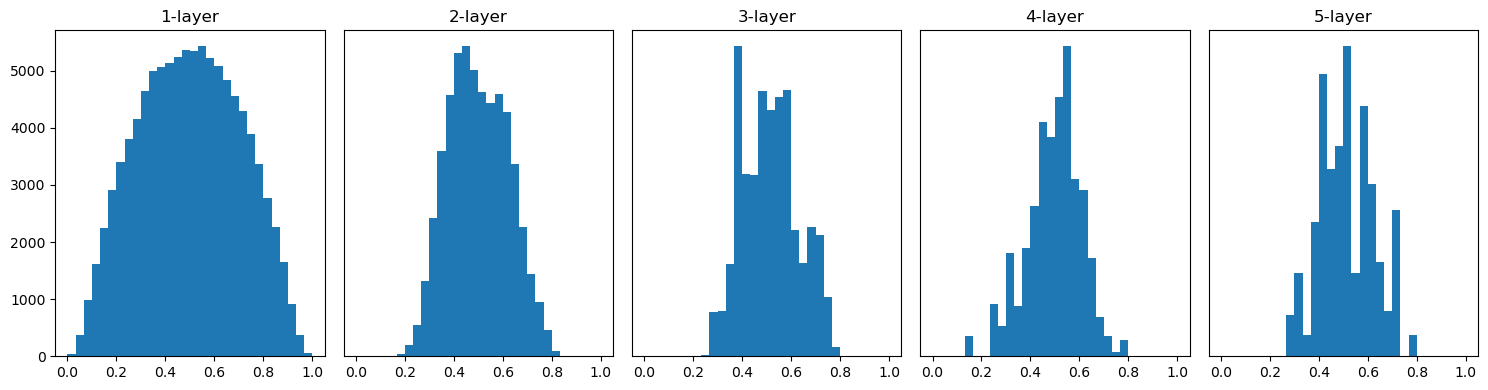

In [16]:
node_num = 100  # 各隠れ層のノード（ニューロン数）
xavier = 1 / np.sqrt(node_num)  # Xavierの基準値

activations = five_layer_network(standard_deviation=xavier)  # 5層のニューラルネットワークを構築
plt.figure(figsize=(15, 4)) 
for i , a in activations.items():
    plt.subplot(1, len(activations), i + 1)  # 1行hidden_layer_size列のサブプロットを作成
    plt.title(str(i + 1) + "-layer")  # タイトルを設定
    plt.hist(a.flatten(), bins=30, range=(0, 1))  # ヒストグラムを表示
    if i != 0:
        plt.yticks([])
        
plt.tight_layout()  # レイアウトを調整
plt.show()  # プロットを表示

- 重みの標準偏差が`1/√n`の時の結果
    - 上位層にいくつれて、ややいびつな形になる
    - これまでより**広がりを持った分布**になる
- この結果からわかること
    - 各層に流れるデータには適度な広がりがある
        - シグモイド関数の表現力も制限されることなく効率的に学習が可能！
> +α  
> 上層に行くほど、いびつになるのはsigmoid関数のせい。tanh関数（双曲線関数）を用いると改善される。  
> これは、sigmoid関数がビミョーに原点対称出ない（0, 0.5で対称）ことに起因している

## ReLUの場合の重みの初期値
- `Xavierの初期値`は、活性化関数が**線形であることを前提**に導いた結果
    - sigmoidやtanhは線形関数なので使用可能
- ReLUを使用するときは...?
    - `Heの初期値`を使用すると良い
        - 前提ノードの数がn個の場合
        $$\sqrt{\frac{2}{n}}$$
        を標準偏差とするガウス分布を用いる

In [17]:
def relu(x):
    return np.maximum(0, x)

def five_layer_network_relu(standard_deviation=1):
    """ 5層のニューラルネットワークを構築し、各層のアクティベーションを計算する """
    x = np.random.randn(1000, 100)  # 1000行100列のランダムなデータを生成
    node_num = 100  # 各隠れ層のノード（ニューロン数）
    hidden_layer_size = 5  # 隠れ層の数
    activations = {}  # ここにアクティベーションの値を格納

    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i - 1]  # 前の層の出力を次の層の入力に設定

        W = np.random.randn(node_num, node_num) * standard_deviation  # 基準値：標準偏差1の正規分布から重みを初期化

        z = np.dot(x, W)  # 行列の積を計算
        a = relu(z)  # シグモイド関数を適用
        activations[i] = a  # アクティベーションの値を保存
    return activations

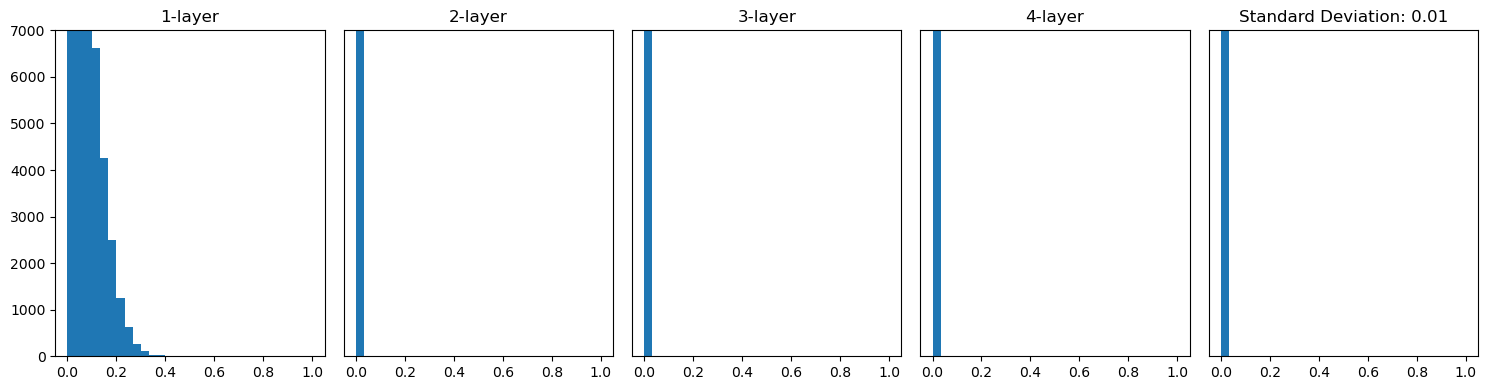

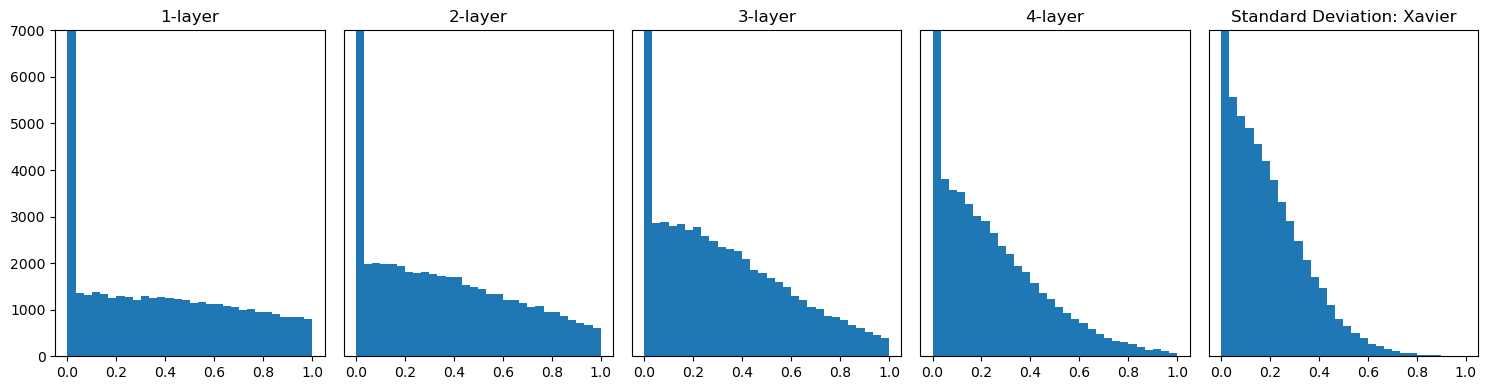

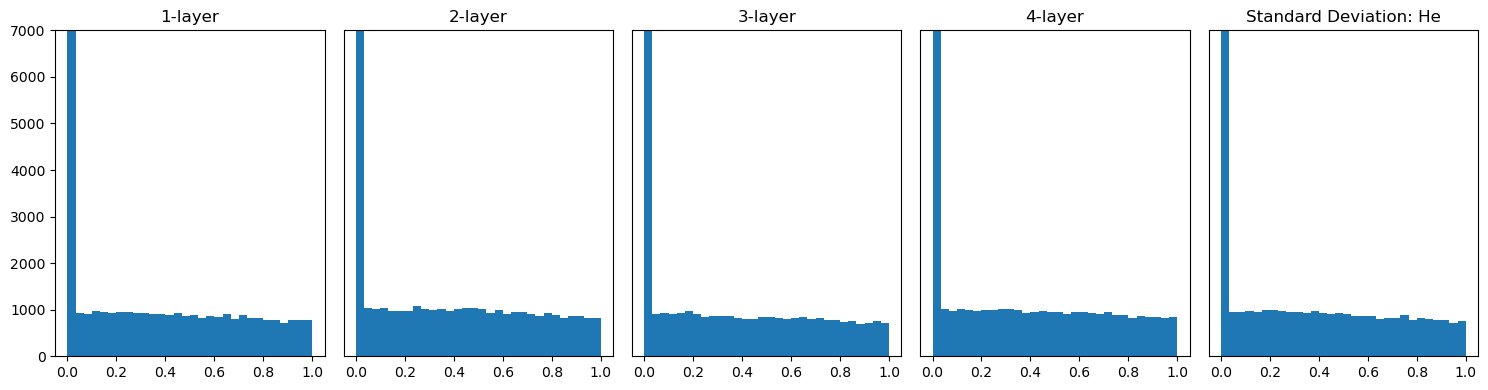

In [18]:
node_num = 100  # 各隠れ層のノード（ニューロン数）
xavier = 1 / np.sqrt(node_num)  # Xavierの基準値
he = np.sqrt(2 / node_num)  # Heの基準値

standard_deviation_list = [0.01, xavier, he]  # 標準偏差のリスト
standard_deviation_naem_list = ["0.01", "Xavier", "He"]  # 標準偏差の名前リスト

for standard_deviation in standard_deviation_list:
    activations = five_layer_network_relu(standard_deviation=standard_deviation)  # 5層のニューラルネットワークを構築
    plt.figure(figsize=(15, 4)) 
    for i , a in activations.items():
        plt.subplot(1, len(activations), i + 1)  # 1行hidden_layer_size列のサブプロットを作成
        plt.title(str(i + 1) + "-layer")  # タイトルを設定
        plt.hist(a.flatten(), bins=30, range=(0, 1))  # ヒストグラムを表示
        plt.ylim(0, 7000)  # y軸の範囲を設定
        if i != 0:
            plt.yticks([])
            
    plt.tight_layout()  # レイアウトを調整
    plt.title(f"Standard Deviation: {standard_deviation_naem_list[standard_deviation_list.index(standard_deviation)]}")  # タイトルを設定
    plt.show()  # プロットを表示

- 上から標準偏差を`0.01, Xavier, He`の結果を示す
    - 0.01の場合：
        - 各層のアクティベーションはとても小さい値になる
        - ニューラルネットワーク上において小さい値が流れる＝逆伝播の際の重みの勾配も小さな値になる
        - **学習がほぼ進まない**
    - Xavierの初期値の場合：
        - 層が深くなるごとに、少しづつ偏りが大きくなっている
        - 層をディープにしていくと、アクティベーションの偏りが大きくなり、**「勾配消失」につながる**
    - Heの初期値の場合：
        - 各層で分布の広がりが均一
        - データの広がりが層を深くしても均一に保たれるので、逆伝播の際も適切な値が保たれる

- **まとめ**
    - それぞれの活性化関数を使う時の初期値の設定
        - ReLU：**Heの初期値**
        - sigmoidやtanhなどのS字カーブ：**Xavierの初期値**

## MNISTデータセットによる重み初期値の比較
- 実際のデータセットを対象に、重みの初期値の違いによるニューラルネットワークの学習への影響を見る
- 使用する初期値
    - std=0.01
    - Xavierの初期値
    - Heの初期値

===========iteration:0===========
0.01 : 2.302497171647466
===========iteration:0===========
Xavier : 2.306172870837873
===========iteration:0===========
He : 2.318470029471848
===========iteration:500===========
0.01 : 2.3018636720347265
===========iteration:500===========
Xavier : 0.912784387192046
===========iteration:500===========
He : 0.38864247338766644
===========iteration:1000===========
0.01 : 2.304461911760127
===========iteration:1000===========
Xavier : 0.3865709906736518
===========iteration:1000===========
He : 0.20791328020503796
===========iteration:1500===========
0.01 : 2.302410311795981
===========iteration:1500===========
Xavier : 0.28935441065476236
===========iteration:1500===========
He : 0.18750498417576325


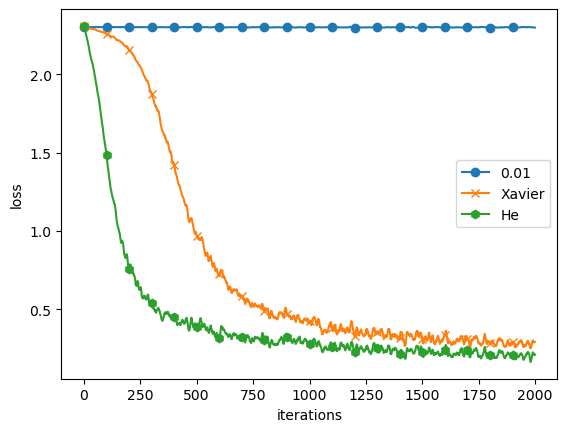

In [19]:
# MNISTデータセットによる重み初期値の比較
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリをパスに追加
import numpy as np
from deep_learning_from_scratch.dataset.mnist import load_mnist
from deep_learning_from_scratch.common.functions import *
import matplotlib.pyplot as plt

# MNISTデータセットの読み込み
(img_train, label_train), (img_test, label_test) = load_mnist(normalize=True, one_hot_label=True)  # 正規化とone-hot表現を適用
# ハイパーパラメータの設定
iters_num = 2000  # 学習の繰り返し回数
train_size = img_train.shape[0]  # 学習データのサイズ(60000)
batch_size = 128  # バッチサイズ
learning_rate = 0.01  # 学習率

# 重み初期化の基準値
node_num = 784  # 入力層のノード数
# standard_deviation_list = [0.01, 1 / np.sqrt(node_num), np.sqrt(2 / node_num)]  # 標準偏差のリスト
# standard_deviation_name_list = ["0.01", "Xavier", "He"]  # 標準偏差の名前リスト
standard_deviation_dic = {"0.01": 0.01, "Xavier": 'sigmoid', "He": 'relu'}  # 標準偏差の辞書
optimizers = SGD(lr=learning_rate)

# ネットワークのインスタンスを作成
networks = {}
train_loss = {}
for key, standard_deviation in standard_deviation_dic.items():
    networks[key] = MultiLayerNet(
        input_size=784,
        hidden_size_list=[100, 100, 100, 100],
        output_size=10,
        weight_init_std=standard_deviation  # 重み初期化の基準値を設定
    )
    train_loss[key] = []  # 学習時の損失を格納するリスト

for i in range(iters_num):
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size)  # ランダムにバッチサイズ分のインデックスを取得(60000の中から100個のインデックスをランダムに選ぶ)
    x_batch = img_train[batch_mask]  # ミニバッチの画像データ
    t_batch = label_train[batch_mask]  # ミニバッチの正解データ

    # 勾配の計算
    for key in standard_deviation_dic.keys():
        # パラメータの更新
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

        # 学習経過を記録
        if i % 500 == 0:
            print( "===========" + "iteration:" + str(i) + "===========")
            loss = networks[key].loss(x_batch, t_batch)
            print(f"{key} : {loss}")

# 学習結果のプロット
markers = {"0.01": "o", "Xavier": "x", "He": "h"}
x = np.arange(iters_num)  # x軸の値（イテレーション数）
for key in standard_deviation_dic.keys():
    plt.plot(
        x, 
        smooth_curve(train_loss[key]), 
        marker=markers[key],
        markevery=100, 
        label=key
        )
plt.xlabel("iterations")
plt.ylabel("loss")
# plt.ylim(0, 1)
plt.legend()
plt.show()

- 条件
    - 5層のニューラルネットワーク
        - 各層のニュートン数は100個
    - 活性化関数ReLU
- 結果（上図）
    - std=0.01のとき
        - まったく学習が進んでない（横這い）
            - 順伝播では、小さな値が流れる（0に近い）のが原因
            - 逆伝播の際に求める勾配が小さいかり、更新が進みにくい
    - XavierとHe
        - 学習がうまくできている
            -Heの初期値の方が学習の効率が良い

- まとめ
    - 重みの初期値もニューラルネットワークの学習において非常に重要！！！！

# Batch Normalization

-   **Batch Normalization**：
    - 強制的にアクティベーションの分布を調整するような手法

## Batch Normalizationのアルゴリズム

- Batch Normalization(以下Batch Norm)の利点
    - 学習を速くすることが可能（学習係数（lr）を大きくできる）
    - 重みの初期値にそれほど依存しない
    - 過学習を抑制

- Batch Normのアイデア
    - 各層のアクティベーション（活性化関数後の出力データ）の分布を適度な広がりを持つように調整すること
    - AffineとReLUの間にBatch Normレイヤを追加する
        - データ分布の正規化を行うレイヤ
        - ミニバッチごとに正規化を行う
            - データの分布が平均が0、分散が1になるように正規化
                $$μB ← \frac{1}{m}\sum_{i=1}^{m}x_i$$
                $$σ_B^2 ← \frac{1}{m}\sum_{i=1}^{m}(x_i - μB)^2$$
                $$x_i' ← \frac{x_i - μB}{\sqrt{σ_B^2 + ε}}$$
                - B：`B={x1, x2, x3,・・・}`というミニバッチとしてm個の入力データ
                - μB：平均
                - σ_B^2：分散
                - ε：小さな値（10e-7）(ゼロ除算を防ぐ)
            - この式は、ミニバッチの入力データを平均0, 分散1のデータに変換するもの
            - この式を活性化関数の前（または後）に挿入して、データの分散の偏りを減らすことが可能

        - 正規化されたデータに対する固有のスケールとシフトで変換を行う
            - 式
            $$y_i ← γx_i' + β$$
            - γ：パラメータ（初期値１）
            - β：パラメータ（初期値０）
            - ２つのパラメータは学習が進むにつれて適した値になる

## Batch Normalizationの評価


- MNISTのデータセットを使用して、Batch Normを使うときと使わない時でどのように変化するか確認する

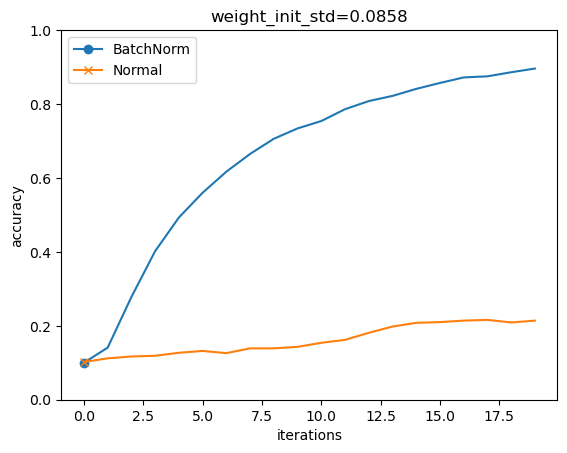

In [20]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリをパスに追加
import numpy as np
import matplotlib.pyplot as plt
from deep_learning_from_scratch.common.functions import *
from deep_learning_from_scratch.dataset.mnist import load_mnist

# MNISTデータセットの読み込み
(img_train, label_train), (img_test, label_test) = load_mnist(normalize=True, one_hot_label=True)  # 正規化とone-hot表現を適用

img_train = img_train[:1000]  # 学習データを1000件に制限
label_train = label_train[:1000]  # 学習データのラベルを1000件に制限

# ハイパーパラメータの設定
max_epoch = 20  # 学習の繰り返し回数
train_size = img_train.shape[0]  # 学習データのサイズ(60000)
batch_size = 100  # バッチサイズ
learning_rate = 0.01  # 学習率

optimizer = SGD(lr=learning_rate)  # SGDのインスタンスを作成

iter_per_epoch = max(train_size // batch_size, 1)  # 1エポックあたりの繰り返し数

weight_scale_list = np.logspace(0, -4, num=16)  # 重み初期化のスケールを設定
# np.logspace(0, -4, num=16)は、10^0から10^-4までの値を16個生成する

network_name_list = ["BatchNorm", "Normal"]

def train(weight_scale):
    epoch_cnt = 0
    cnt = 0
    train_acc = {}
    networks = {}
    for network_name in network_name_list:
        if network_name == "BatchNorm":
            networks[network_name] = MultiLayerNetExtend(
                input_size=784,
                hidden_size_list=[100, 100, 100, 100, 100],
                output_size=10,
                weight_init_std=weight_scale_list[4],
                use_batchnorm=True,  # Batch Normalizationを使用
            )
        else:
            networks[network_name] = MultiLayerNet(
                input_size=784,
                hidden_size_list=[100, 100, 100, 100, 100],
                output_size=10,
                weight_init_std=weight_scale_list[4],
            )
        train_acc[network_name] = [] 

    for i in range(1000000000):
        # ミニバッチの取得
        batch_mask = np.random.choice(train_size, batch_size)  # ランダムにバッチサイズ分のインデックスを取得(60000の中から100個のインデックスをランダムに選ぶ)
        x_batch = img_train[batch_mask]  # ミニバッチの画像データ
        t_batch = label_train[batch_mask]  # ミニバッチの正解データ

        # 勾配の計算とパラメータの更新
        for network_name in network_name_list:
            grads = networks[network_name].gradient(x_batch, t_batch)  # 勾配を計算
            optimizer.update(networks[network_name].params, grads)  # パラメータを更新
        
            # loss = networks[network_name].loss(x_batch, t_batch)  # 損失を計算
            # train_acc[network_name].append(loss)  # 損失を記録

        # 学習経過を記録
        if i % iter_per_epoch == 0:
            # print( "===========" + "epoch:" + str(epoch_cnt) + "===========")
            for network_name in network_name_list:
                # loss = networks[network_name].loss(x_batch, t_batch)
                # print(f"{network_name} : {loss}")
                acc = networks[network_name].accuracy(img_train, label_train)  # 学習データに対する精度を計算
                train_acc[network_name].append(acc)
                # print(f"{network_name} : {acc}")
            epoch_cnt += 1
            if epoch_cnt >= max_epoch:
                break
    return train_acc

train_acc = train(weight_scale_list[4])  # 重み初期化のスケールを指定して学習
markers = {"BatchNorm": "o", "Normal": "x"}
x = np.arange(max_epoch)  # x軸の値（エポック数）
for key in network_name_list:
    plt.plot(
        x, 
        train_acc[key], 
        marker=markers[key],
        markevery=100, 
        label=key
        )
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.ylim(0, 1)
plt.title(f"weight_init_std={weight_scale_list[4]:.4f}")  # タイトルを設定
plt.legend()
plt.show()


- Batch Normの方が正解率の上昇が早いことがわかる！
- 様々な初期値のスケールを与え、学習の進行を確認する

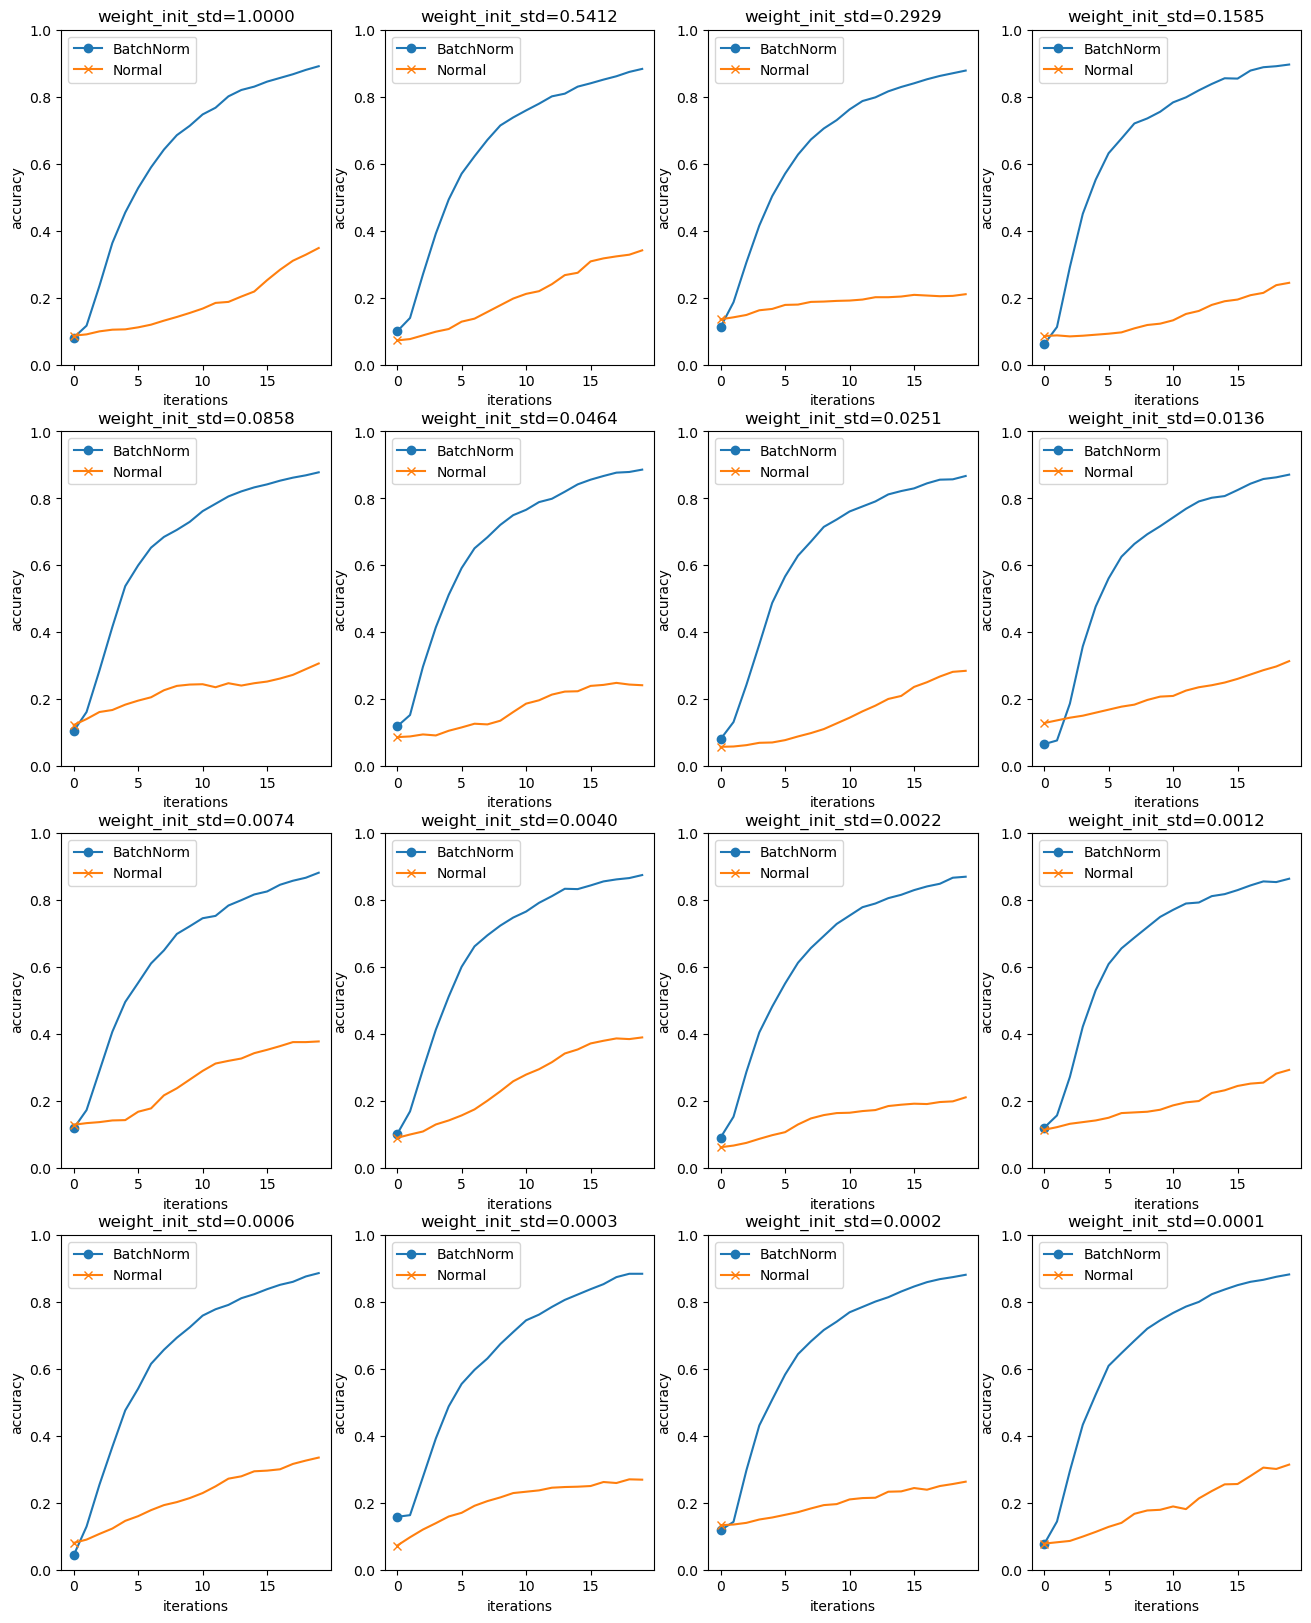

In [21]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリをパスに追加
import numpy as np
import matplotlib.pyplot as plt
from deep_learning_from_scratch.common.functions import *
from deep_learning_from_scratch.dataset.mnist import load_mnist

# MNISTデータセットの読み込み
(img_train, label_train), (img_test, label_test) = load_mnist(normalize=True, one_hot_label=True)  # 正規化とone-hot表現を適用

img_train = img_train[:1000]  # 学習データを1000件に制限
label_train = label_train[:1000]  # 学習データのラベルを1000件に制限

# ハイパーパラメータの設定
max_epoch = 20  # 学習の繰り返し回数
train_size = img_train.shape[0]  # 学習データのサイズ(60000)
batch_size = 100  # バッチサイズ
learning_rate = 0.01  # 学習率

optimizer = SGD(lr=learning_rate)  # SGDのインスタンスを作成

iter_per_epoch = max(train_size // batch_size, 1)  # 1エポックあたりの繰り返し数

weight_scale_list = np.logspace(0, -4, num=16)  # 重み初期化のスケールを設定
# np.logspace(0, -4, num=16)は、10^0から10^-4までの値を16個生成する

network_name_list = ["BatchNorm", "Normal"]

plt.figure(figsize=(16, 20)) 
for i in range(len(weight_scale_list)):
    plt.subplot(4,4,i+1)
    train_acc = train(weight_scale_list[i])  # 重み初期化のスケールを指定して学習
    markers = {"BatchNorm": "o", "Normal": "x"}
    x = np.arange(max_epoch)  # x軸の値（エポック数）
    for key in network_name_list:
        plt.plot(
            x, 
            train_acc[key], 
            marker=markers[key],
            markevery=100, 
            label=key
            )
    plt.xlabel("iterations")
    plt.ylabel("accuracy")
    plt.ylim(0, 1)
    plt.title(f"weight_init_std={weight_scale_list[i]:.4f}")  # タイトルを設定
    plt.legend()
plt.show()

- 初期値の標準偏差が様々な値になったとしても、ほとんどのケースで**Batch Normalの方が学習が早い**！！
> **Batch Normalization**  
> どんな初期値にもロバスト（依存しない）になり、学習の進行を促進させることができる！

# 正則化

- 機械学習の大きな問題：**過学習**
> **過学習**：  
> 訓練データに適応しすぎて、訓練データに含まれな他のデータにうまく対応できない状態
- 過学習を抑制するには...？

## 過学習
- 過学習の原因：
    - パラメータを大量に持ち、表現力が高い（層が多いなど）
    - 訓練データが少ない
- わざと過学習を発生させてみる(MNISTを使用)
    - 訓練データを300個に減少
    - 7層のニューラルネットワーク（ニューロン数は各層100個, ReLUを使用）

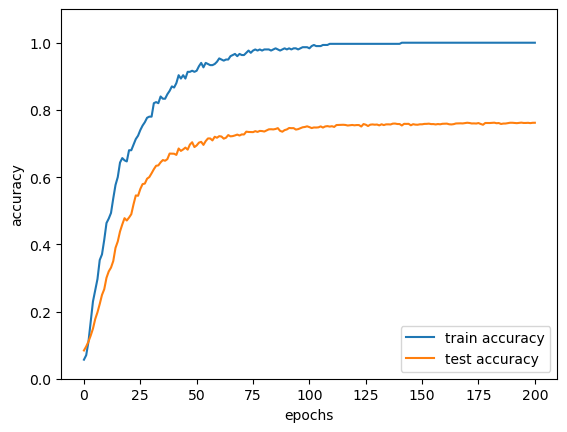

最終的な精度の隔たり: 0.23819999999999997


In [22]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリをパスに追加
import numpy as np
import matplotlib.pyplot as plt
from deep_learning_from_scratch.common.functions import *
from deep_learning_from_scratch.dataset.mnist import load_mnist

# MNISTデータセットの読み込み
(img_train, label_train), (img_test, label_test) = load_mnist(normalize=True, one_hot_label=True)  # 正規化とone-hot表現を適用
img_train = img_train[:300]  # 学習データを300件に制限
label_train = label_train[:300]  # 学習データのラベルを300件に制限

network = MultiLayerNet(
    input_size=784,
    hidden_size_list=[100, 100, 100, 100, 100, 100],
    output_size=10,
)
optimizer = SGD(lr=0.01)  # 学習係数lr=0.01のSGDでパラメータを更新

max_epoch = 201  # 学習の繰り返し回数
train_size = img_train.shape[0]
batch_size = 100  # バッチサイズ

train_loss_list = []  # 学習時の損失を格納するリスト
train_acc_list = []  # 学習時の精度を格納するリスト
test_acc_list = []  # テスト時の精度を格納するリスト

iter_per_epoch = max(train_size // batch_size, 1)  # 1エポックあたりの繰り返し数
epoch_cnt = 0  # エポック数のカウンタ

for i in range(1000000000):
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size) 
    x_batch = img_train[batch_mask]  
    t_batch = label_train[batch_mask] 

    grads = network.gradient(x_batch, t_batch)  # 勾配を計算
    optimizer.update(network.params, grads)  # パラメータを更新

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(img_train, label_train)  # 学習データに対する精度を計算
        test_acc = network.accuracy(img_test, label_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_cnt += 1
        if epoch_cnt >= max_epoch:
            break
# 学習結果のプロット
plt.plot(np.arange(len(train_acc_list)), train_acc_list, label='train accuracy')  # 学習時の精度をプロット
plt.plot(np.arange(len(test_acc_list)), test_acc_list, label='test accuracy')  # テスト時の精度をプロット
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.1)
plt.legend()
plt.show()
print(f"最終的な精度の隔たり: {abs(train_acc_list[-1] - test_acc_list[-1])}")  # 最終的な精度の隔たりを表示

- 結果
    - 訓練データを用いて計測した精度：
        - 100エポックあたりからほとんど100%
    - テストデータを用いて計測した精度：
        - 7割程度の認識精度して出ていない
- 認識精度の大きな隔たりは、訓練データだけに適応しすぎてしまった結果である！

## Weight decay
> **Weight decay**  
> 学習課程において、**大きな重みを持つことに対してペナルティを課す**ことで過学習を抑制する手法
- 過学習＝重みパラメータが過度に大きな値をとることで発生
- ニューラルネットワークの学習は、**損失関数の値を小さくすること**が目的
    - 重みの二乗ノルムを損失関数に加算することで重みが大きくなることを防ぐ
    - 重みを`W`とすれば、二乗ノルムのWeight decayは
    $$\frac{1}{2}λW^2$$
    - となり、これを損失関数に加算する。
    - `λ`：正則化の強さをコントロールするハイパラ
        - 大きな値にするほど、大きな重みをとることに対して強いペナルティを課すようになる
    > ※ **二乗ノルム**：ベクトルの各要素を 2 乗して合計したもの  
    > （例： $ \|\mathbf{W}\|_2^2 = \sum_i W_i^2 $ ）。  
    > ユークリッドノルムの 2 乗とも呼ばれ、重みの大きさを数値的に表す。
- Weight decayはこの $ \frac{1}{2}λW^2 $ をすべての重みに対して加算する
    - $ \frac{1}{2} $ は、 $ \frac{1}{2}λW^2 $ の微分結果を $ λW $ にするため
    - 誤差逆伝播法による結果に、正則化項の微分 $ λW $ を加算する

- 先ほどの実験に対して、 $λ=1$ としてWeight decayを定期用する

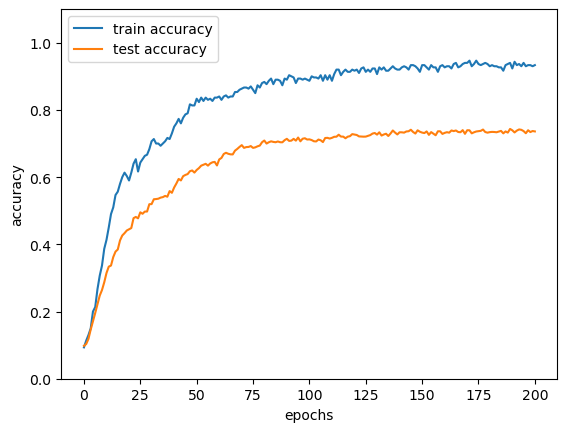

最終的な精度の隔たり: 0.19733333333333336


In [23]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリをパスに追加
import numpy as np
import matplotlib.pyplot as plt
from deep_learning_from_scratch.common.functions import *
from deep_learning_from_scratch.dataset.mnist import load_mnist

# MNISTデータセットの読み込み
(img_train, label_train), (img_test, label_test) = load_mnist(normalize=True, one_hot_label=True)  # 正規化とone-hot表現を適用
img_train = img_train[:300]  # 学習データを300件に制限
label_train = label_train[:300]  # 学習データのラベルを300件に制限

###################################
# weight decayの設定を追加
weight_decay_lambda = 0.1  # 重み減衰の係数
###################################

network = MultiLayerNet(
    input_size=784,
    hidden_size_list=[100, 100, 100, 100, 100, 100],
    output_size=10,
    weight_decay_lambda=weight_decay_lambda  # 重み減衰の係数を設定
)
optimizer = SGD(lr=0.01)  # 学習係数lr=0.01のSGDでパラメータを更新

max_epoch = 201  # 学習の繰り返し回数
train_size = img_train.shape[0]
batch_size = 100  # バッチサイズ

train_loss_list = []  # 学習時の損失を格納するリスト
train_acc_list = []  # 学習時の精度を格納するリスト
test_acc_list = []  # テスト時の精度を格納するリスト

iter_per_epoch = max(train_size // batch_size, 1)  # 1エポックあたりの繰り返し数
epoch_cnt = 0  # エポック数のカウンタ

for i in range(1000000000):
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size) 
    x_batch = img_train[batch_mask]  
    t_batch = label_train[batch_mask] 

    grads = network.gradient(x_batch, t_batch)  # 勾配を計算
    optimizer.update(network.params, grads)  # パラメータを更新

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(img_train, label_train)  # 学習データに対する精度を計算
        test_acc = network.accuracy(img_test, label_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_cnt += 1
        if epoch_cnt >= max_epoch:
            break
# 学習結果のプロット
plt.plot(np.arange(len(train_acc_list)), train_acc_list, label='train accuracy')  # 学習時の精度をプロット
plt.plot(np.arange(len(test_acc_list)), test_acc_list, label='test accuracy')  # テスト時の精度をプロット
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.1)
plt.legend()
plt.show()
print(f"最終的な精度の隔たり: {abs(train_acc_list[-1] - test_acc_list[-1])}")  # 最終的な精度の隔たりを表示

- 結果：
    - 訓練データとテストデータの精度の隔たりは、**小さくなった！**
        - 過学習が抑制された
    - 訓練データの認識精度が**100%に達していない** 
        - これはいいこと！！
        - あくまで、訓練データに対して適用しすぎないことが目的！！
> ちなみに、λの値を大きくしすぎるとテストデータも訓練データも認識精度は減少するので注意  
> また、Weight decayは簡単に認識できるが、モデルが複雑になるとこれだけでは対応が困難

## Dropout
> **Dropout**  
> **ニューロンをランダムに削除**しながら学習する手法
- 訓練時に隠れ層のニューロンをランダムに選び、削除する
- 削除されたニューロンは、信号の伝達が行われなくなる
- `訓練時`：データが流れるたびに、消去するニューロンをランダムに選択する
- `テスト時`：各ニューロンの出力に対して、訓練時に削除した割合を乗算する

### Dropoutの実装
- 今回は、わかりやすさを重視
- 訓練の際に適切な計算を行えば、順伝播には単にデータを流すだけでよい
    - 削除した割合を乗算する必要がない
    - ディープラーニングのフレームワークではそのような実装がされている

In [24]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        """
        ドロップアウトの初期化
        :param dropout_ratio: ドロップアウト率（0.0〜1.0の範囲）
        """
        self.dropout_ratio = dropout_ratio  # ドロップアウト率
        self.mask = None  # ドロップアウトのマスク

    def forward(self, x, train_flg=True):
        """
        フォワードパス
        :param x: 入力データ
        :param train_flg: 学習時はTrue、推論時はFalse
        :return: ドロップアウトを適用した出力データ
        """
        if train_flg:  # 学習時のみドロップアウトを適用
            """
            削除するニューロンをFalseとして格納するマスクを生成
            np.random.rand(*x.shape)は、xと同じ形状のランダムな値を生成
            その値がドロップアウト率より大きい場合はTrue、そうでない場合はFalseとなる
            """
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio  
            return x * self.mask  # マスクを適用
        else:
            return x * (1 - self.dropout_ratio)  # 推論時はドロップアウトを適用しない

    def backward(self, dout):
        """
        バックワードパス
        :param dout: 上流からの勾配
        :return: ドロップアウトを適用した勾配
        """
        return dout * self.mask  # マスクを適用して逆伝播（ReLUと同様）

- 実験
    - 7層のネットワーク（各層のニューロンは100個、活性化関数はReLU）
    - Dropoutを適用する

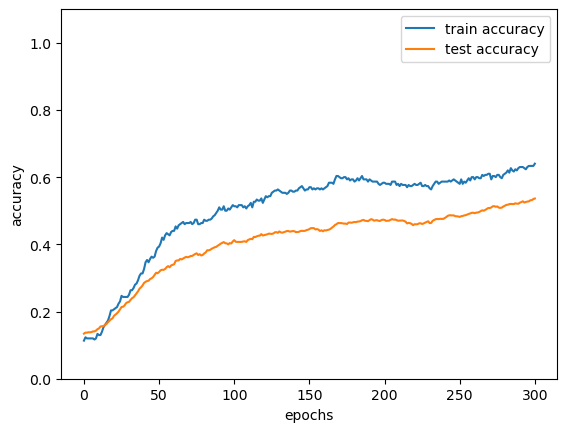

最終的な精度の隔たり: 0.10370000000000001


In [25]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリをパスに追加
import numpy as np
import matplotlib.pyplot as plt
from deep_learning_from_scratch.common.functions import *
from deep_learning_from_scratch.dataset.mnist import load_mnist

# MNISTデータセットの読み込み
(img_train, label_train), (img_test, label_test) = load_mnist(normalize=True, one_hot_label=True)  # 正規化とone-hot表現を適用
img_train = img_train[:300]  # 学習データを300件に制限
label_train = label_train[:300]  # 学習データのラベルを300件に制限

#########
# ドロップアウトの設定を追加
use_dropout = True  # ドロップアウトを使用するかどうか
dropout_ration = 0.2  # ドロップアウト率
#########

network = MultiLayerNetExtend(
    input_size=784,
    hidden_size_list=[100, 100, 100, 100, 100, 100],
    output_size=10,
    use_dropout=use_dropout,
    dropout_ration=dropout_ration
)

optimizer = SGD(lr=0.01)  # 学習係数lr=0.01のSGDでパラメータを更新

max_epoch = 301  # 学習の繰り返し回数
train_size = img_train.shape[0]
batch_size = 100  # バッチサイズ

train_loss_list = []  # 学習時の損失を格納するリスト
train_acc_list = []  # 学習時の精度を格納するリスト
test_acc_list = []  # テスト時の精度を格納するリスト

iter_per_epoch = max(train_size // batch_size, 1)  # 1エポックあたりの繰り返し数
epoch_cnt = 0  # エポック数のカウンタ

for i in range(1000000000):
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size) 
    x_batch = img_train[batch_mask]  
    t_batch = label_train[batch_mask] 

    grads = network.gradient(x_batch, t_batch)  # 勾配を計算
    optimizer.update(network.params, grads)  # パラメータを更新

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(img_train, label_train)  # 学習データに対する精度を計算
        test_acc = network.accuracy(img_test, label_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_cnt += 1
        if epoch_cnt >= max_epoch:
            break
# 学習結果のプロット
plt.plot(np.arange(len(train_acc_list)), train_acc_list, label='train accuracy')  # 学習時の精度をプロット
plt.plot(np.arange(len(test_acc_list)), test_acc_list, label='test accuracy')  # テスト時の精度をプロット
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.1)
plt.legend()
plt.show()
print(f"最終的な精度の隔たり: {abs(train_acc_list[-1] - test_acc_list[-1])}")  # 最終的な精度の隔たりを表示

- 結果
    - 訓練データとテストデータの認識精度の隔たりはより小さくなった
    - 訓練データが100%の認識精度に到達することがなくなった
    - 7層という高い表現力のネットワークでも過学習を抑制できている！

> **アンサンブル学習**  
> 複数のモデル(同じ構造)を個別に学習させ、推論時にはその複数の出力の平均する手法  
> これをすることで認識精度が向上する。  
> Dropoutも概念的には同じで、ランダム削除することで毎回異なるモデルを学習していると解釈できる。  最後に削除した割合を乗算することで、モデルの平均をとっている。

# ハイパーパラメータの検証

> **ハイパーパラメータ**  
> 各層のニューロンの数やバッチサイズ、パラメータの更新の際の学習係数、Weight decayなど
- ハイパーパラメータも非常に大きな影響を与える
- できるだけ効率的にハイパーパラメータの値を探索したい

## 検証データ
- **ハイパーパラメータは、テストデータを使って性能評価してはいけない！！**
- なぜ？
    - テストデータを使ってハイパーパラメータ（以下ハイパラ）を調整すると、ハイパラはテストデータに対して過学習を起こすことになってしまう...
    - 他のデータには対応できない汎化性能が低いモデルになってしまう
- ハイパラを調整するには...?
    > **検証データ**  
    > ハイパラ専用の確認データ
    - この検証データを使用することでハイパラの良さを評価する
- データセットにはあらかじめ訓練データ、検証データ、テストデータの３つに分離されているモノもある
    - 逆に検証データがないもの、そもそも分割されていないものもある
    - 分割がない場合は、自ら分割する必要がある

In [29]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリをパスに追加
import numpy as np
import matplotlib.pyplot as plt
from deep_learning_from_scratch.common.functions import *
from deep_learning_from_scratch.dataset.mnist import load_mnist
from deep_learning_from_scratch.common.util import shuffle_dataset

# MNISTデータセットの読み込み
(img_train, label_train), (img_test, label_test) = load_mnist(normalize=True, one_hot_label=True)  # 正規化とone-hot表現を適用

"""
訓練データをシャッフルする
データセットによっては、データに偏りがある場合があるため、シャッフルすることで学習の安定性を向上させる
"""
img_train, label_train = shuffle_dataset(img_train, label_train)  # データセットをシャッフル

# 検証データの分割
validation_rate = 0.2  # 検証データの割合
validation_num = int(img_train.shape[0] * validation_rate)  # 検証データの数
print(f"検証データの数: {validation_num}")  # 検証データの数を表示(12000)

# 検証データと学習データの分割
img_val = img_train[:validation_num]  # 検証データの画像
label_val = label_train[:validation_num]  # 検証データのラベル
img_train = img_train[validation_num:]  # 検証データを除いた学習データの画像
label_train = label_train[validation_num:]  # 検証データを除いた学習データのラベル

検証データの数: 12000


## ハイパーパラメータの最適化
- 調整のポイント
    - ハイパラの「良い値」が**存在する範囲を徐々に絞り込んでいく**こと！
    - 最初は大まかに範囲を設定し、その範囲の中からランダムにハイパラを選び出し（サンプリング）、その値で認識精度の評価を行う
    - 何回か繰り返し行い、認識精度の結果を観察し、その結果からハイパラの「良い値」の範囲を狭めていく
    - 大まかにと指定するとは、「10の階乗」のスケールで指定する（ $ 10^{-3} や 10^3$ ）
        - 対数スケールで指定するとも表現する
- ハイパラの調整する際に注意すべき点
    - **学習には非常に字間がかかる**
    - ハイパラの探索では、筋の悪そうなハイパラは早い段階で見切りをつける必要がある
    - 学習のための**エポックを小さくして、一回の評価に要する時間を短縮するのが有効**
- ハイパラ調整のフロー  
    1. ハイパラの範囲を設定する
    2. 設定されたハイパラの範囲から、ランダムにサンプリングする
    3. ステップ2でサンプリングされたハイパラの値を使用して学習を行い、検証データで認識精度を評価する（エポックを小さく設定）
    4. ステップ2とステップ3をある回数（100回など） を繰り返し、それらの認識精度の結果から、ハイパラの範囲を狭めていく
> **ベイズ最適化**  
> ハイパラの最適化においてより洗礼された手法  
> ベイズ最適化は、ベイズの定理を中心とした数学を駆使して、より厳密に効率よく最適化を行う


## ハイパーパラメータ最適化の実装
- MNISTデータセットを使用し、ハイパラ最適化を行う
    - 学習係数とWeight decayの強さをコントロールする係数を探索
- ハイパラの検証
    - Weight decay係数： $10^{-8} から 10^{-4}$
    - 学習係数(lr)： $10^{-6} から 10^{-2}$
    - pythonでの実装は以下の通り
        ```py
        import numpy as np
        weight_decay = 10 ** np.random.uniform(-8, -4)
        lr = 10 ** np.random.uniform(-6, -2)
        ```

Best-1(val acc:0.8) | lr:0.009149592168502375, weight decay:4.87840214604072e-07
Best-2(val acc:0.77) | lr:0.0077843311676048625, weight decay:2.2134706300760606e-08
Best-3(val acc:0.76) | lr:0.00813334738394983, weight decay:1.1914701206407001e-06
Best-4(val acc:0.76) | lr:0.009579561032284935, weight decay:3.573703119335323e-08
Best-5(val acc:0.72) | lr:0.005413933844617255, weight decay:5.64419037687501e-06
Best-6(val acc:0.7) | lr:0.007069858025601031, weight decay:1.9831000182311997e-05
Best-7(val acc:0.66) | lr:0.004810177008514922, weight decay:2.5849742050349802e-05
Best-8(val acc:0.64) | lr:0.00580400758052488, weight decay:2.7284110762959752e-08
Best-9(val acc:0.62) | lr:0.0038671447283580786, weight decay:4.3183308094378817e-07
Best-10(val acc:0.61) | lr:0.0032550898261867324, weight decay:3.5537735805257105e-08
Best-11(val acc:0.6) | lr:0.00376020917686051, weight decay:7.758834500602742e-08
Best-12(val acc:0.56) | lr:0.004374571352904871, weight decay:3.0147211998835867e-0

<Figure size 1600x2000 with 0 Axes>

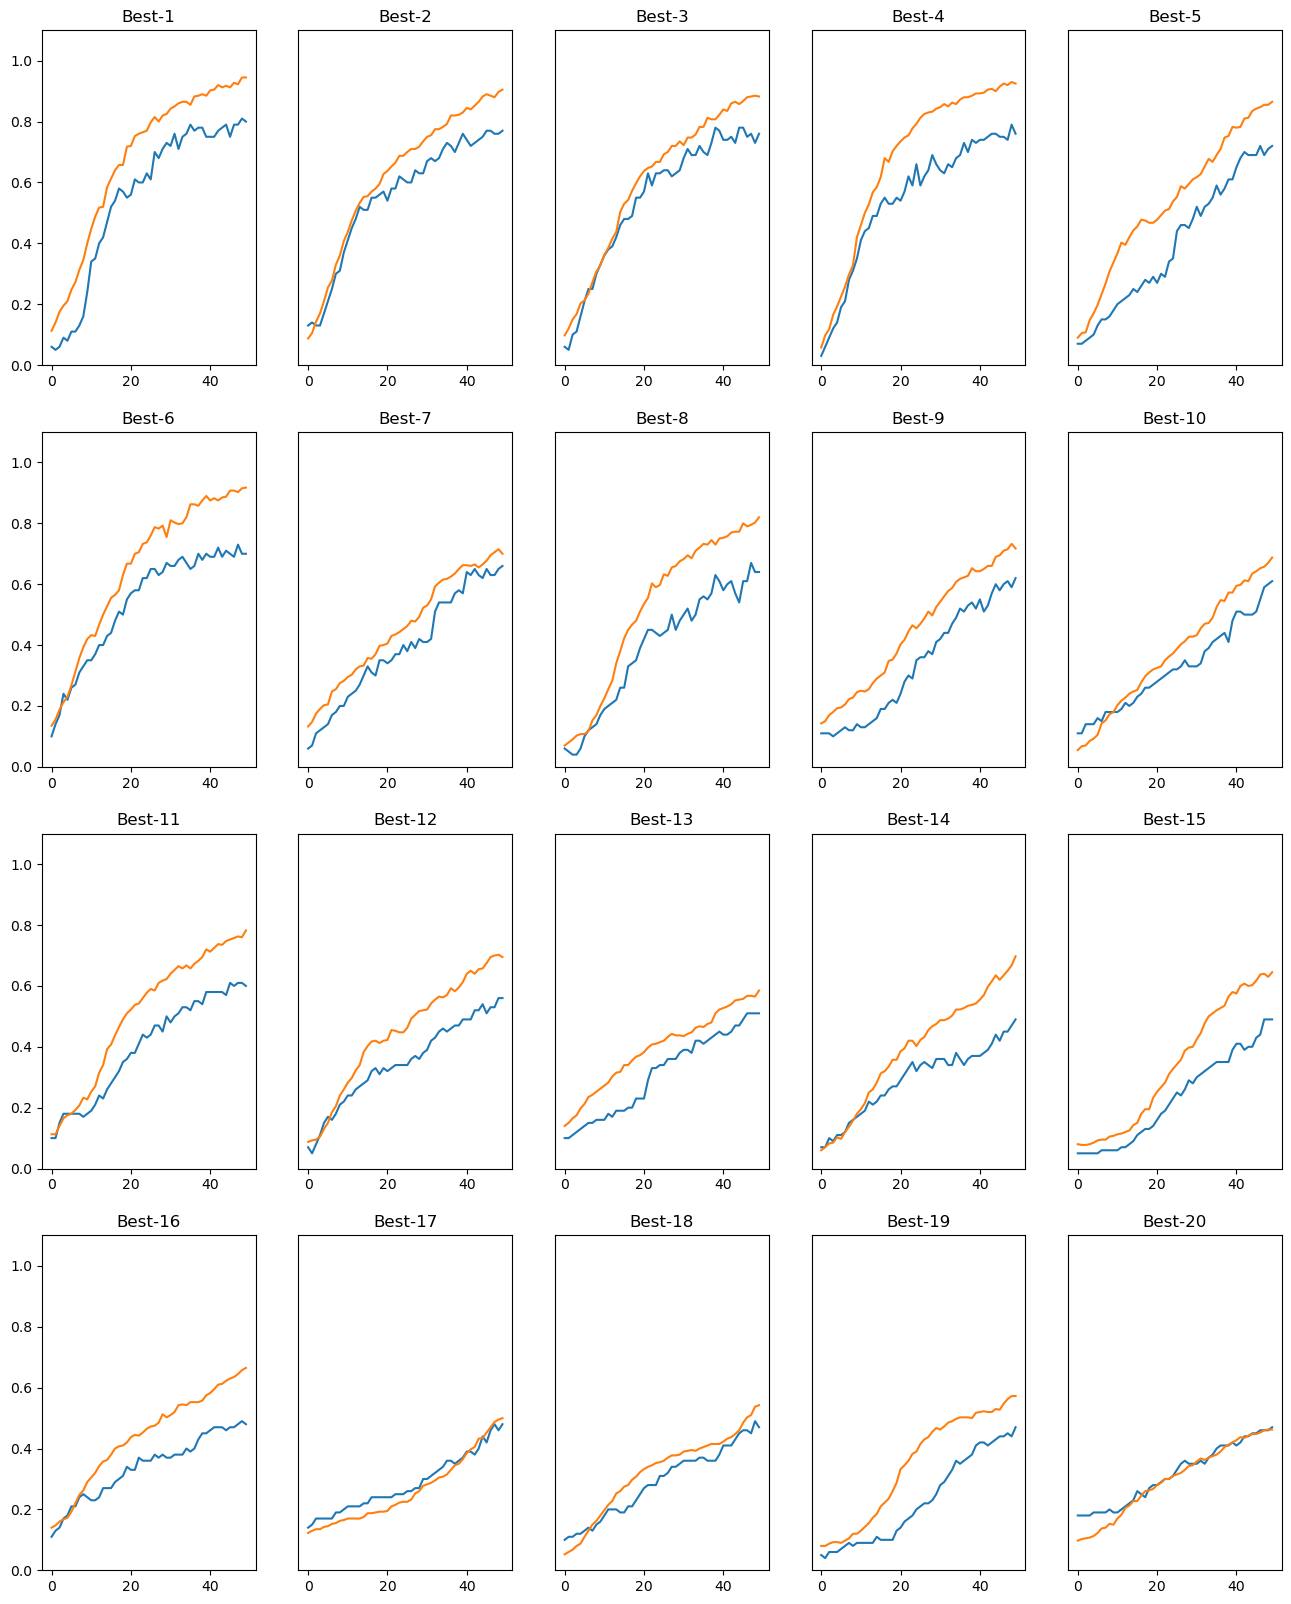

In [41]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリをパスに追加
import numpy as np
import matplotlib.pyplot as plt
from deep_learning_from_scratch.common.functions import *
from deep_learning_from_scratch.dataset.mnist import load_mnist

# MNISTデータセットの読み込み
(img_train, label_train), (img_test, label_test) = load_mnist(normalize=True)
img_train = img_train[:500]
label_train = label_train[:500] 

# 検証データの分割
validation_rate = 0.2  # 検証データの割合
validation_num = int(img_train.shape[0] * validation_rate)  # 検証データの数

# 検証データと学習データの分割
img_val = img_train[:validation_num]  # 検証データの画像
label_val = label_train[:validation_num]  # 検証データのラベル
img_train = img_train[validation_num:]  # 検証データを除いた学習データの画像
label_train = label_train[validation_num:]  # 検証データを除いた学習データのラベル

def train(lr, weight_decay):
    network = MultiLayerNet(
        input_size=784,
        hidden_size_list=[100, 100, 100, 100, 100, 100],
        output_size=10,
        weight_decay_lambda=weight_decay
    )

    optimizer = SGD(lr=lr)  # 学習係数lr=0.01のSGDでパラメータを更新

    max_epoch = 50  # 学習の繰り返し回数
    train_size = img_train.shape[0]
    batch_size = 100  # バッチサイズ

    train_acc_list = []  # 学習時の精度を格納するリスト
    val_acc_list = []  # 検証時の精度を格納するリスト

    iter_per_epoch = max(train_size // batch_size, 1)  # 1エポックあたりの繰り返し数
    epoch_cnt = 0  # エポック数のカウンタ

    for i in range(1000000000):
        # ミニバッチの取得
        batch_mask = np.random.choice(train_size, batch_size) 
        x_batch = img_train[batch_mask]  
        t_batch = label_train[batch_mask] 

        grads = network.gradient(x_batch, t_batch)  # 勾配を計算
        optimizer.update(network.params, grads)  # パラメータを更新

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(img_train, label_train)  # 学習データに対する精度を計算
            val_acc = network.accuracy(img_val, label_val)  # 検証データに対する精度を計算
            train_acc_list.append(train_acc)
            val_acc_list.append(val_acc)

            epoch_cnt += 1
            if epoch_cnt >= max_epoch:
                break

    return train_acc_list, val_acc_list

result_val = {}  # 検証結果を格納する辞書
result_train = {}  # 学習結果を格納する辞書

plt.figure(figsize=(16, 20))   # プロットのサイズを設定
for i in range(100):  # 20回の試行を行う
    ###############
    # 探索したハイパーパラメータの範囲を指定
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    ###############

    # 学習の実行
    train_acc_list, val_acc_list = train(lr=lr, weight_decay=weight_decay)
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    result_val[key] = val_acc_list
    result_train[key] = train_acc_list

# 学習結果のプロット
graph_draw_num = 20
i = 0
plt.figure(figsize=(16, 20))  # プロットのサイズを設定

for key, val_acc_list in sorted(result_val.items(), key=lambda x: x[1][-1], reverse=True):  # 検証結果をキーでソート
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    train_acc_list = result_train[key]  # 学習時の精度を取得
    plt.subplot(4, 5, i + 1)  # 4行5列のサブプロットを作成
    plt.title(f"Best-{i+1}")
    plt.ylim(0, 1.1)  # y軸の範囲を設定

    if i % 5: # 5の倍数でない場合
        plt.yticks([])

    x = np.arange(len(val_acc_list))  # x軸の値（エポック数）
    plt.plot(x, val_acc_list, label='val accuracy')  # 検証時の精度をプロット
    plt.plot(x, train_acc_list, label='train accuracy')  # 学習時の精度をプロット
    
    i += 1
    if i >= graph_draw_num:  # 指定した数だけプロットしたら終了
        break

plt.show()


- 結果
    - Best-5ぐらいまでは順調に学習が進んでいる
    - Best-5までのハイパラの数値を確認してみると...
        - 学習係数（lr）：0.001~0.01( $10^{-3} から 10^{-2}$ )
        - Weight decay： $10^{-8} から 10^{-6}$
        - の範囲がいい！
- この結果から範囲をもう一度しぼって実行してみる
    

Best-1(val acc:0.79) | lr:0.006510152289979085, weight decay:2.5817722881133035e-07
Best-2(val acc:0.78) | lr:0.0054190596201923, weight decay:3.214542619135349e-08
Best-3(val acc:0.77) | lr:0.009912055658015458, weight decay:1.576594651553358e-07
Best-4(val acc:0.76) | lr:0.009729621736776346, weight decay:4.3017501360096766e-08
Best-5(val acc:0.76) | lr:0.00749937494473975, weight decay:6.100931127768626e-08
Best-6(val acc:0.76) | lr:0.007106283187918895, weight decay:3.506780919561144e-08
Best-7(val acc:0.76) | lr:0.007200001810335252, weight decay:4.1866458799392967e-07
Best-8(val acc:0.76) | lr:0.008086100317283072, weight decay:3.634859731506484e-08
Best-9(val acc:0.76) | lr:0.0073350601711026754, weight decay:1.8111695233373e-08
Best-10(val acc:0.76) | lr:0.005804214909375263, weight decay:1.283426466641751e-08
Best-11(val acc:0.75) | lr:0.00897549929708076, weight decay:3.8914931711550434e-08
Best-12(val acc:0.75) | lr:0.00741501132110476, weight decay:5.172779720649355e-08
Bes

<Figure size 1600x2000 with 0 Axes>

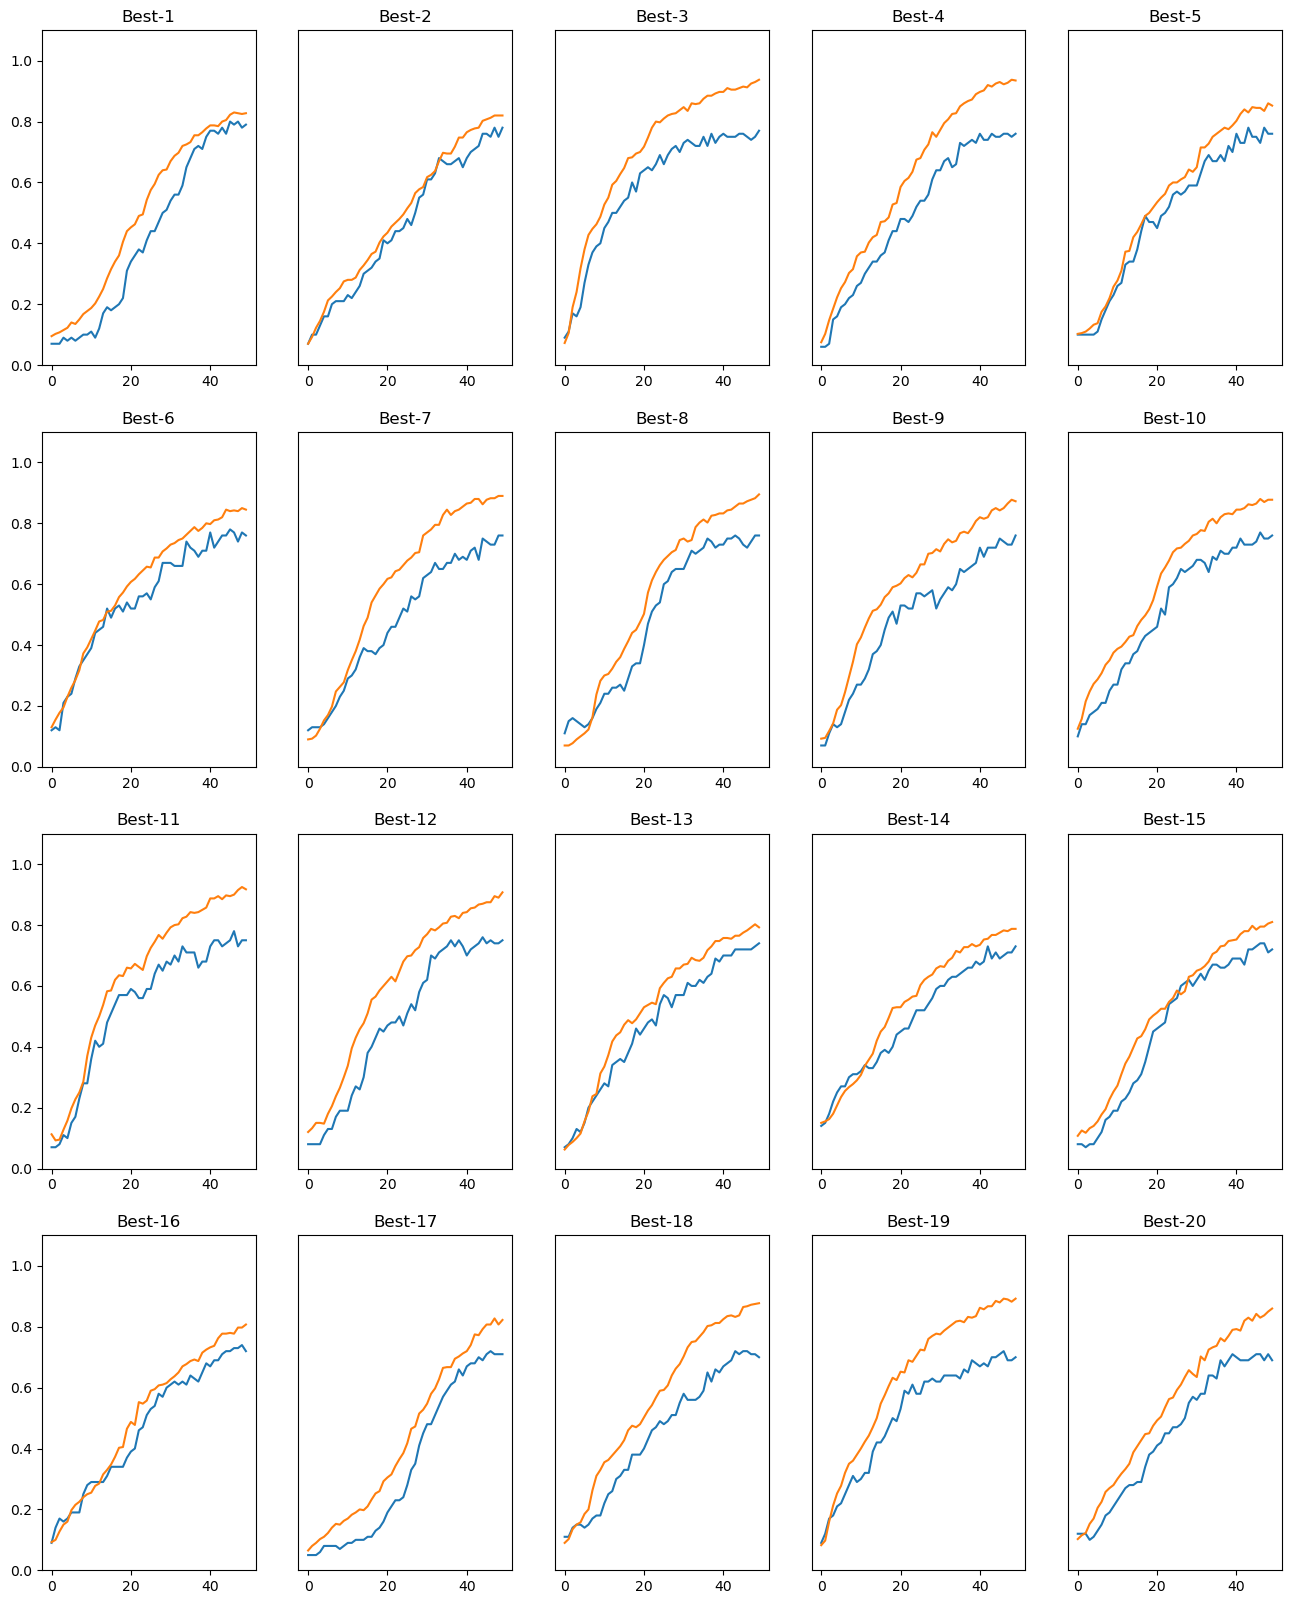

In [42]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリをパスに追加
import numpy as np
import matplotlib.pyplot as plt
from deep_learning_from_scratch.common.functions import *
from deep_learning_from_scratch.dataset.mnist import load_mnist

# MNISTデータセットの読み込み
(img_train, label_train), (img_test, label_test) = load_mnist(normalize=True)
img_train = img_train[:500]
label_train = label_train[:500] 

# 検証データの分割
validation_rate = 0.2  # 検証データの割合
validation_num = int(img_train.shape[0] * validation_rate)  # 検証データの数

# 検証データと学習データの分割
img_val = img_train[:validation_num]  # 検証データの画像
label_val = label_train[:validation_num]  # 検証データのラベル
img_train = img_train[validation_num:]  # 検証データを除いた学習データの画像
label_train = label_train[validation_num:]  # 検証データを除いた学習データのラベル

def train(lr, weight_decay):
    network = MultiLayerNet(
        input_size=784,
        hidden_size_list=[100, 100, 100, 100, 100, 100],
        output_size=10,
        weight_decay_lambda=weight_decay
    )

    optimizer = SGD(lr=lr)  # 学習係数lr=0.01のSGDでパラメータを更新

    max_epoch = 50  # 学習の繰り返し回数
    train_size = img_train.shape[0]
    batch_size = 100  # バッチサイズ

    train_acc_list = []  # 学習時の精度を格納するリスト
    val_acc_list = []  # 検証時の精度を格納するリスト

    iter_per_epoch = max(train_size // batch_size, 1)  # 1エポックあたりの繰り返し数
    epoch_cnt = 0  # エポック数のカウンタ

    for i in range(1000000000):
        # ミニバッチの取得
        batch_mask = np.random.choice(train_size, batch_size) 
        x_batch = img_train[batch_mask]  
        t_batch = label_train[batch_mask] 

        grads = network.gradient(x_batch, t_batch)  # 勾配を計算
        optimizer.update(network.params, grads)  # パラメータを更新

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(img_train, label_train)  # 学習データに対する精度を計算
            val_acc = network.accuracy(img_val, label_val)  # 検証データに対する精度を計算
            train_acc_list.append(train_acc)
            val_acc_list.append(val_acc)

            epoch_cnt += 1
            if epoch_cnt >= max_epoch:
                break

    return train_acc_list, val_acc_list

result_val = {}  # 検証結果を格納する辞書
result_train = {}  # 学習結果を格納する辞書

plt.figure(figsize=(16, 20))   # プロットのサイズを設定
for i in range(100):  # 20回の試行を行う
    ###############
    # 探索したハイパーパラメータの範囲を指定
    weight_decay = 10 ** np.random.uniform(-8, -6)  # 範囲を更新
    lr = 10 ** np.random.uniform(-3, -2)  # 範囲を更新
    ###############

    # 学習の実行
    train_acc_list, val_acc_list = train(lr=lr, weight_decay=weight_decay)
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    result_val[key] = val_acc_list
    result_train[key] = train_acc_list

# 学習結果のプロット
graph_draw_num = 20
i = 0
plt.figure(figsize=(16, 20))  # プロットのサイズを設定

for key, val_acc_list in sorted(result_val.items(), key=lambda x: x[1][-1], reverse=True):  # 検証結果をキーでソート
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    train_acc_list = result_train[key]  # 学習時の精度を取得
    plt.subplot(4, 5, i + 1)  # 4行5列のサブプロットを作成
    plt.title(f"Best-{i+1}")
    plt.ylim(0, 1.1)  # y軸の範囲を設定

    if i % 5: # 5の倍数でない場合
        plt.yticks([])

    x = np.arange(len(val_acc_list))  # x軸の値（エポック数）
    plt.plot(x, val_acc_list, label='val accuracy')  # 検証時の精度をプロット
    plt.plot(x, train_acc_list, label='train accuracy')  # 学習時の精度をプロット
    
    i += 1
    if i >= graph_draw_num:  # 指定した数だけプロットしたら終了
        break

plt.show()


- 結果
    - 範囲を狭めたことで全体的に精度が良くなった
- このように範囲を狭めることで最適なハイパラの値を選定することができる！！ 